### Importing Libraries

In [498]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.stats import probplot
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from clusteval import clusteval
from sklearn.decomposition import PCA
from datetime import date
import wget

### Loading Dataset

In [499]:
url="https://github.com/hdb1603/bank-customers-segmentation/raw/main/Bank_customers_transactions.zip"
file=wget.download(url)
data=pd.read_csv(file)

100% [........................................................................] 25360448 / 25360448

### Data Preprocessing

In [500]:
data.shape

(1048567, 9)

In [501]:
## Checking for na values ####
print(data.isna().sum())

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


In [502]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [503]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [504]:
### Checking for attribute mean,median ,Q1,Q3,IQR ##
data.describe()

CustAccountBalance  TransactionTime  TransactionAmount (INR)
count          1046198.00       1048567.00               1048567.00
mean            115403.54        157087.53                  1574.34
std             846485.38         51261.85                  6574.74
min                  0.00             0.00                     0.00
25%               4721.76        124030.00                   161.00
50%              16792.18        164226.00                   459.03
75%              57657.36        200010.00                  1200.00
max          115035495.10        235959.00               1560034.99

In [505]:
data.duplicated().sum()

0

### Data Features exploration

#### Droping TransactionID and CustomerID from Dataset

In [506]:
data=data.drop(['TransactionID','CustomerID'],axis=1)

In [507]:
data.head(100)

CustomerDOB CustGender CustLocation  CustAccountBalance TransactionDate  \
0      10/1/94          F   JAMSHEDPUR            17819.05          2/8/16   
1       4/4/57          M      JHAJJAR             2270.69          2/8/16   
2     26/11/96          F       MUMBAI            17874.44          2/8/16   
3      14/9/73          F       MUMBAI           866503.21          2/8/16   
4      24/3/88          F  NAVI MUMBAI             6714.43          2/8/16   
..         ...        ...          ...                 ...             ...   
95     25/5/88          M     KASHIPUR             4001.86          6/8/16   
96    15/10/94          M         ETAH               78.33          6/8/16   
97     14/7/87          M    NEW DELHI            14916.95          6/8/16   
98     10/6/89          F        DELHI            62706.81          6/8/16   
99     18/9/77          F      KOLKATA            22588.09          6/8/16   

    TransactionTime  TransactionAmount (INR)  
0            143207                    25.00  
1            141858                 27999.00  
2            142712                   459.00  
3            142714                  2060.00  
4            181156                  1762.50  
..              ...                      ...  
95           162303                    96.00  
96           174150                   179.00  
97           174346                   830.00  
98           182434                  3380.00  
99           182603                   810.00  

[100 rows x 7 columns]

In [508]:
data['CustGender'].value_counts()

M    765530
F    281936
T         1
Name: CustGender, dtype: int64

In [509]:
data.drop(data[data['CustGender'].isin(['T'])].index,axis=0,inplace=True)
data['CustGender'].unique()

array(['F', 'M', nan], dtype=object)

In [510]:
data = data[~data['CustomerDOB'].isna()]
data.CustomerDOB = pd.to_datetime(data.CustomerDOB,errors='coerce')

#### Converting Customers Date of Births in their Age

In [511]:
def Age(birthdate):
    today = date.today()
    Age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return Age

In [512]:
data['Age'] = data.CustomerDOB.apply(Age)

In [518]:
data.loc[data['Age']<0]

CustomerDOB CustGender CustLocation  CustAccountBalance  \
1        2057-04-04          M      JHAJJAR             2270.69   
15       2068-10-07          F    NEW DELHI             1283.12   
30       2067-01-21          F    NEW DELHI           298461.05   
51       2066-07-25          M         PUNE             9956.49   
79       2067-05-25          M        DELHI           257966.29   
...             ...        ...          ...                 ...   
1048506  2070-09-20          M  NAVI MUMBAI               41.82   
1048510  2048-07-15          M       HOWRAH           416244.74   
1048536  2033-05-10          M    NEW DELHI            92173.35   
1048544  2071-05-10          M       MUMBAI            25414.52   
1048552  2071-08-21          F    NEW DELHI           235620.05   

        TransactionDate  TransactionTime  TransactionAmount (INR)  Age  
1                2/8/16           141858                 27999.00  -35  
15               1/8/16           125725                   250.00  -47  
30               3/8/16           160642                   500.00  -45  
51               5/8/16           133141                   145.00  -44  
79               1/8/16           204252                   195.64  -45  
...                 ...              ...                      ...  ...  
1048506         18/9/16           182310                   878.18  -49  
1048510         18/9/16           184959                  1695.00  -26  
1048536         18/9/16           184556                  1319.04  -11  
1048544         18/9/16           182015                   400.00  -49  
1048552         18/9/16           184234                  1058.00  -49  

[75063 rows x 8 columns]

In [521]:
data = data[data['Age']>0]
data.drop('CustomerDOB',axis=1,inplace=True)
data.shape

KeyError: "['CustomerDOB'] not found in axis"

(912768, 7)

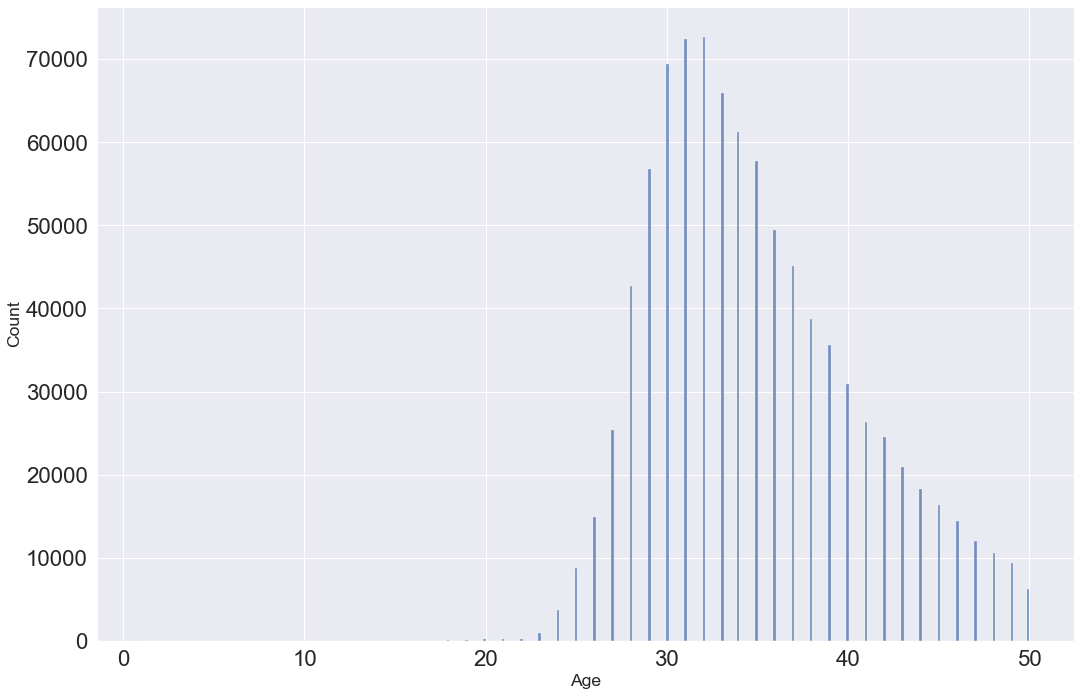

In [522]:
plt.figure(figsize=(18,12),dpi=70)
sns.histplot(x='Age',data=data)
data=data.drop(data[(data['Age'] > 100)].index)
data.shape

### Treating na values

In [523]:
for col in data.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(data[col].isna().sum()/len(data)*100,2)) + '%')

Percentage of null values of CustGender: 0.0%
Percentage of null values of CustLocation: 0.02%
Percentage of null values of CustAccountBalance: 0.22%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of Age: 0.0%


In [524]:
for col in data.columns:
    print("Percentage of unique values of {}:".format(col),str(np.round(data[col].nunique()/len(data)*100,2)) + '%')

Percentage of unique values of CustGender: 0.0%
Percentage of unique values of CustLocation: 0.85%
Percentage of unique values of CustAccountBalance: 15.15%
Percentage of unique values of TransactionDate: 0.01%
Percentage of unique values of TransactionTime: 8.87%
Percentage of unique values of TransactionAmount (INR): 8.62%
Percentage of unique values of Age: 0.01%


In [525]:
data=data[~data['CustGender'].isna()]

In [526]:
data = data[~data['CustLocation'].isna()]

In [527]:
data.CustAccountBalance = data.CustAccountBalance.fillna(data.
                                                         groupby('CustLocation')['CustAccountBalance'].transform('mean'))

In [528]:
data = data[~data.CustAccountBalance.isna()]

In [529]:
data.isna().sum()

CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Age                        0
dtype: int64

In [530]:
data.shape

(912457, 7)

In [531]:
data.TransactionDate = pd.to_datetime(data.TransactionDate,errors='coerce')

In [532]:
data['TransactionMonth'] = data.TransactionDate.dt.month
data['TransactionMonthName'] = data.TransactionDate.dt.month_name()
data['TransactionDay'] = data.TransactionDate.dt.day
data['TransactionDayName'] = data.TransactionDate.dt.day_name()

In [533]:
data.drop('TransactionDate',axis=1,inplace=True)

In [534]:
data.head(-50)

CustGender CustLocation  CustAccountBalance  TransactionTime  \
0                F   JAMSHEDPUR            17819.05           143207   
2                F       MUMBAI            17874.44           142712   
3                F       MUMBAI           866503.21           142714   
4                F  NAVI MUMBAI             6714.43           181156   
5                F     ITANAGAR            53609.20           173940   
...            ...          ...                 ...              ...   
1048503          M      GURGAON            84348.94           181343   
1048505          M    NIZAMABAD            74003.49           181739   
1048507          M      GURGAON            10381.09           182503   
1048508          M    PANCHKULA            42860.88           183250   
1048509          M        DELHI            13957.66           185716   

         TransactionAmount (INR)  Age  TransactionMonth TransactionMonthName  \
0                          25.00   27                 2             February   
2                         459.00   25                 2             February   
3                        2060.00   48                 2             February   
4                        1762.50   34                 2             February   
5                         676.00   50                 2             February   
...                          ...  ...               ...                  ...   
1048503                   599.00   36                 9            September   
1048505                  3197.00   29                 9            September   
1048507                   505.00   32                 9            September   
1048508                   134.00   42                 9            September   
1048509                   245.00   28                 9            September   

         TransactionDay TransactionDayName  
0                     8             Monday  
2                     8             Monday  
3                     8             Monday  
4                     8             Monday  
5                     8             Monday  
...                 ...                ...  
1048503              18             Sunday  
1048505              18             Sunday  
1048507              18             Sunday  
1048508              18             Sunday  
1048509              18             Sunday  

[912407 rows x 10 columns]

### Exploratory Data Analysis (EDA) of Preprocessed Dataset

Skewness of CustAccountBalance: 28.78210160879207
Kurtosis of CustAccountBalance: 1497.5619794539423
Distribution Plot of CustAccountBalance:


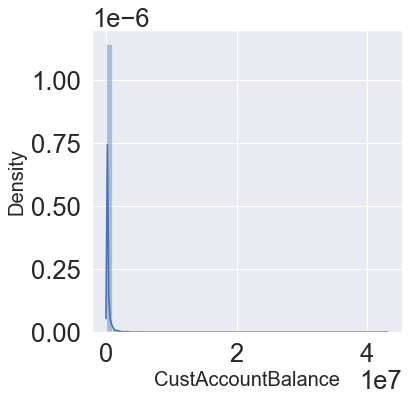

Box Plot of CustAccountBalance:


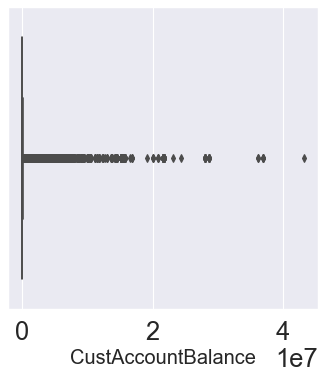

Quantile-Quantile Plot of CustAccountBalance:


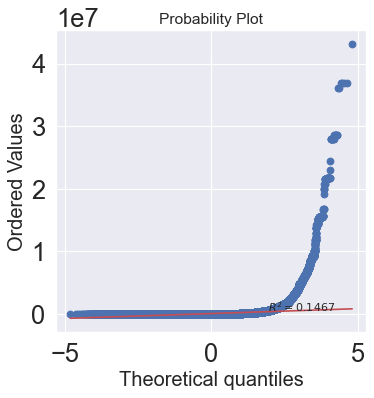

Skewness of TransactionAmount (INR): 69.06681143456832
Kurtosis of TransactionAmount (INR): 13139.53222540371
Distribution Plot of TransactionAmount (INR):


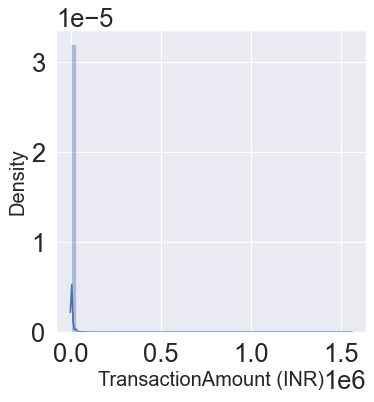

Box Plot of TransactionAmount (INR):


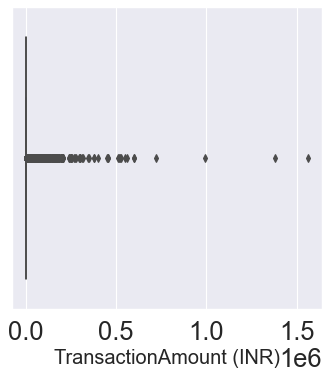

Quantile-Quantile Plot of TransactionAmount (INR):


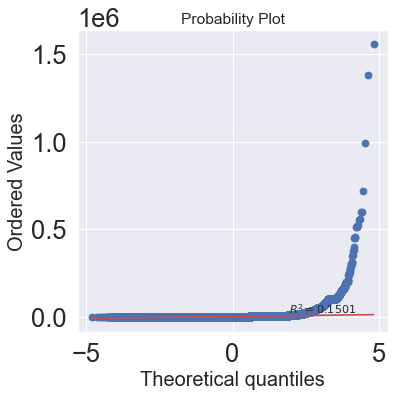

In [535]:
for col in data.columns:
    if data[col].dtypes == np.float64:
        print("Skewness of {}:".format(col),data[col].skew())
        print("Kurtosis of {}:".format(col),data[col].kurt())
        plt.figure(figsize=(5,5),dpi=80)
        print("Distribution Plot of {}:".format(col))
        sns.distplot(data[col])
        plt.show()
        print("Box Plot of {}:".format(col))
        plt.figure(figsize=(5,5),dpi=80)
        sns.boxplot(data[col])
        plt.show()
        print("Quantile-Quantile Plot of {}:".format(col))
        plt.figure(figsize=(5,5),dpi=80)
        probplot(data[col],plot=plt,rvalue=True)
        plt.show()

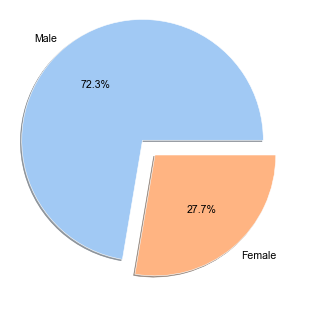

In [536]:
labels = ["Male","Female"]
values = data.CustGender.value_counts().values
col=sns.color_palette("pastel")
explode = (0.16,0)
plt.figure(figsize=(10,10),dpi=40)
plt.pie(values,labels=labels,explode=explode,shadow=1,
        autopct='%1.1f%%',colors=col,textprops={'fontsize': 19,"color":'Black'});

##### A significant proportion of bank customers are males accounting for about 72% of the total share

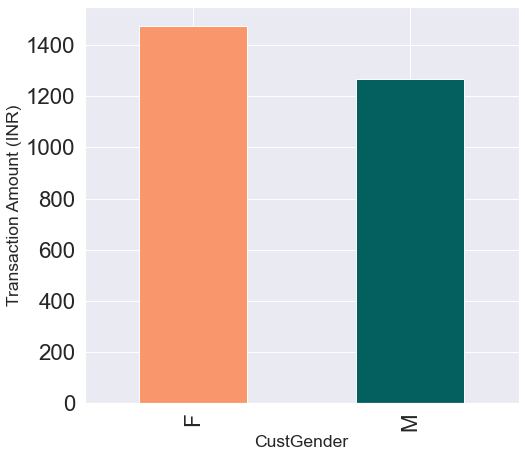

In [537]:
plt.figure(figsize=(8,7.5),dpi=70)
ax = data.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',
                                                                       color=('#F9966B','#045F5F'))
plt.ylabel('Transaction Amount (INR)');

###### At an average, females transactions amounts are slightly higher than those of males.

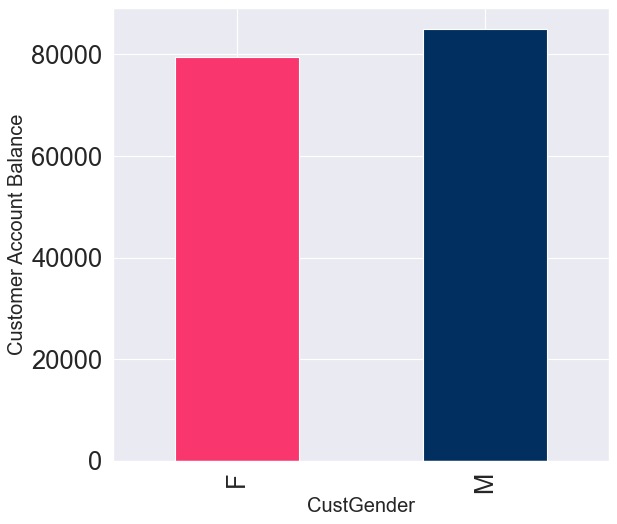

In [538]:
plt.figure(figsize=(8,7.5),dpi=80)
ax = data.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',
                                                                  color=['#F9366E','#012F5F'])
plt.ylabel('Customer Account Balance');

##### On average, male customers have higher account balances in comparison to their females.

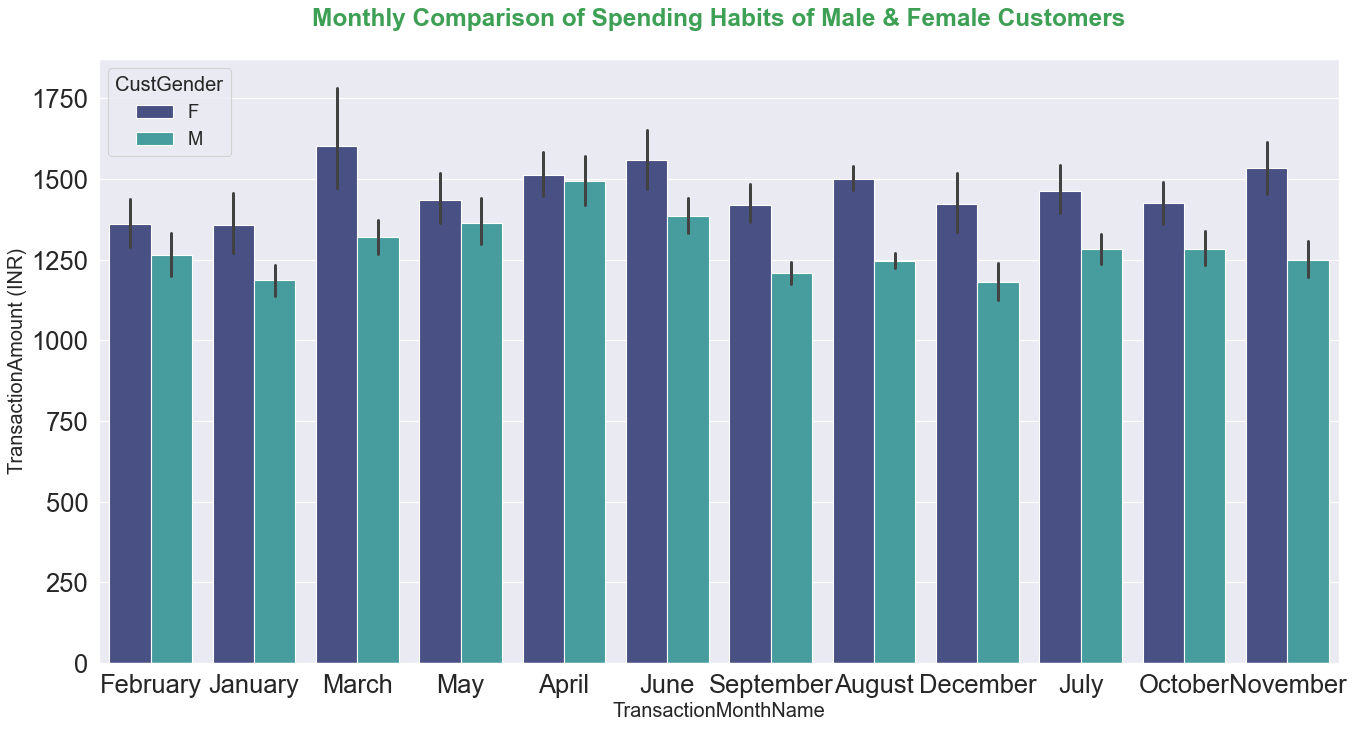

In [539]:
plt.figure(figsize=(20,10),dpi=80)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
sns.barplot(data=data,x='TransactionMonthName',y='TransactionAmount (INR)',palette="mako",hue='CustGender')

sns.set(font_scale=2)
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=22,fontweight='bold',color='#3EA055',pad=30);

##### Male customers make higher transactions than their female only in the months February and April. 
##### In all the remaining months, female customers do higher transactions. Therefore, the bank should provide more special offers and incentives to female customers because they are likely to be more active in making higher transactions almost throughout the entire year. 
##### Higher value transactions are mostly done during the months of March, April and June.

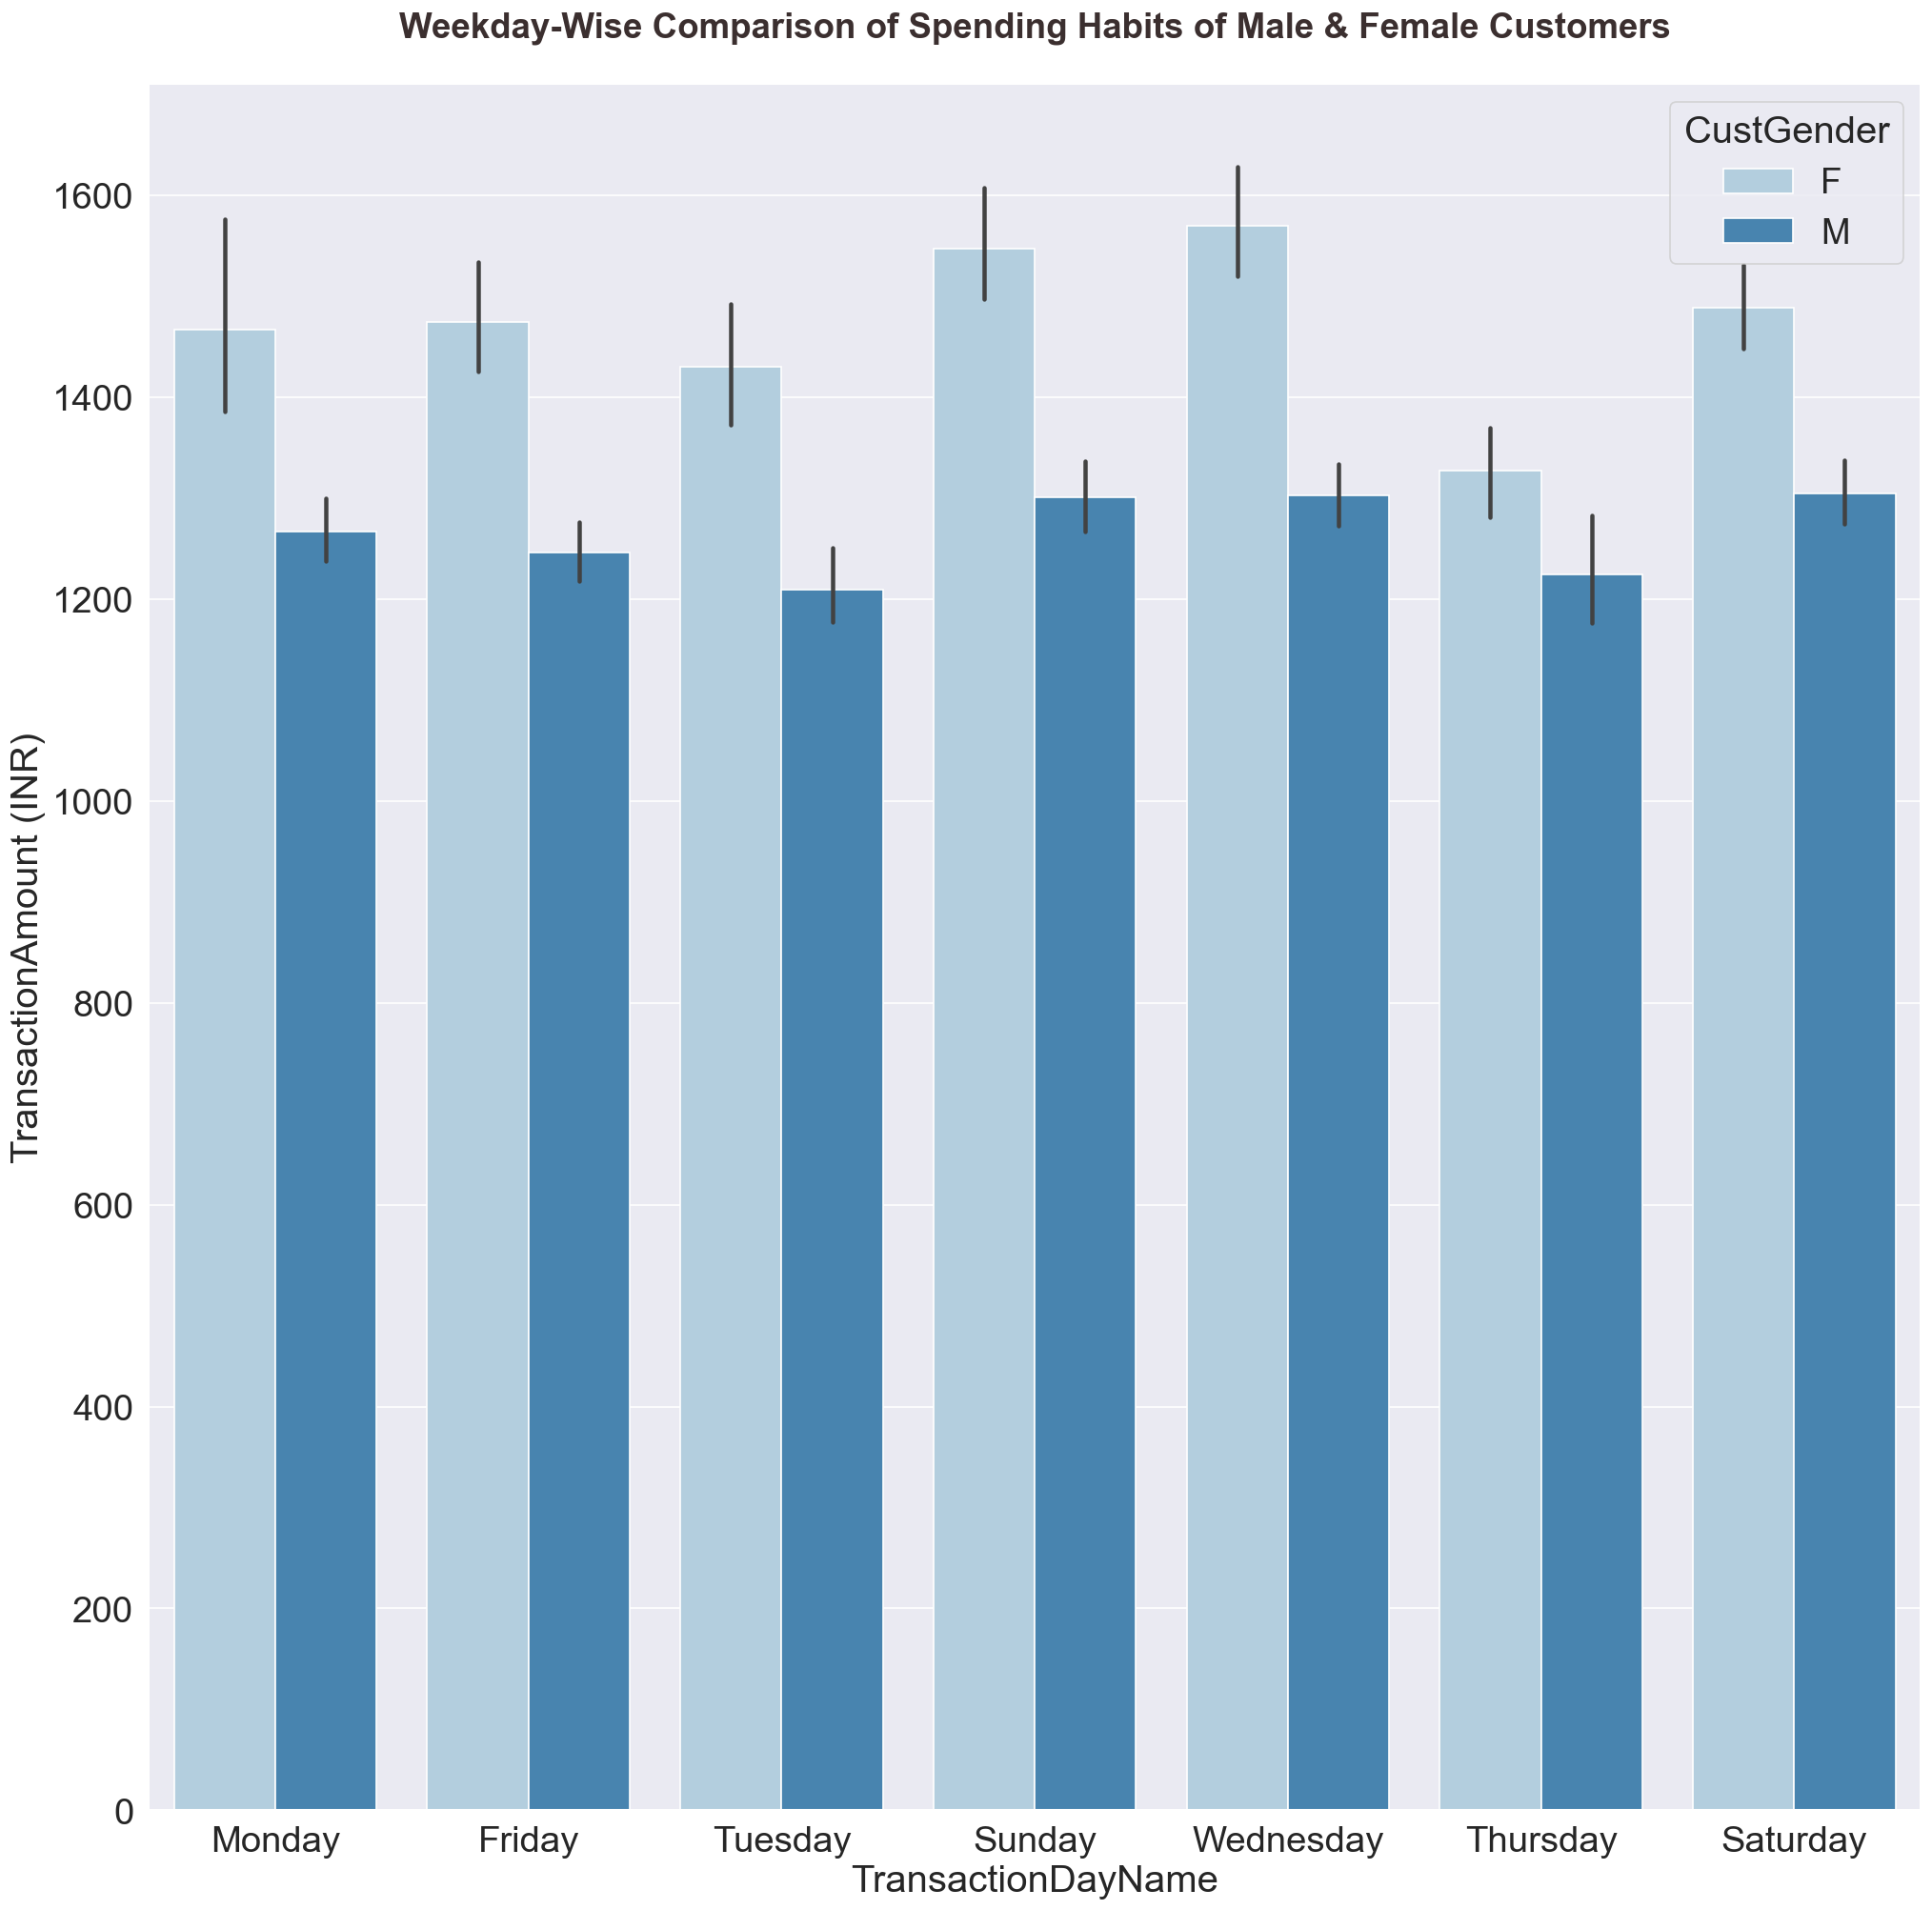

In [540]:
plt.figure(figsize=(20,20),dpi=120)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
sns.barplot(data=data,x='TransactionDayName',y='TransactionAmount (INR)',palette='Blues',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=22,fontweight='bold',color='#3B2F2F',pad=30);

##### Female customers perform higher transactions than their male counterparts in almost every week day.

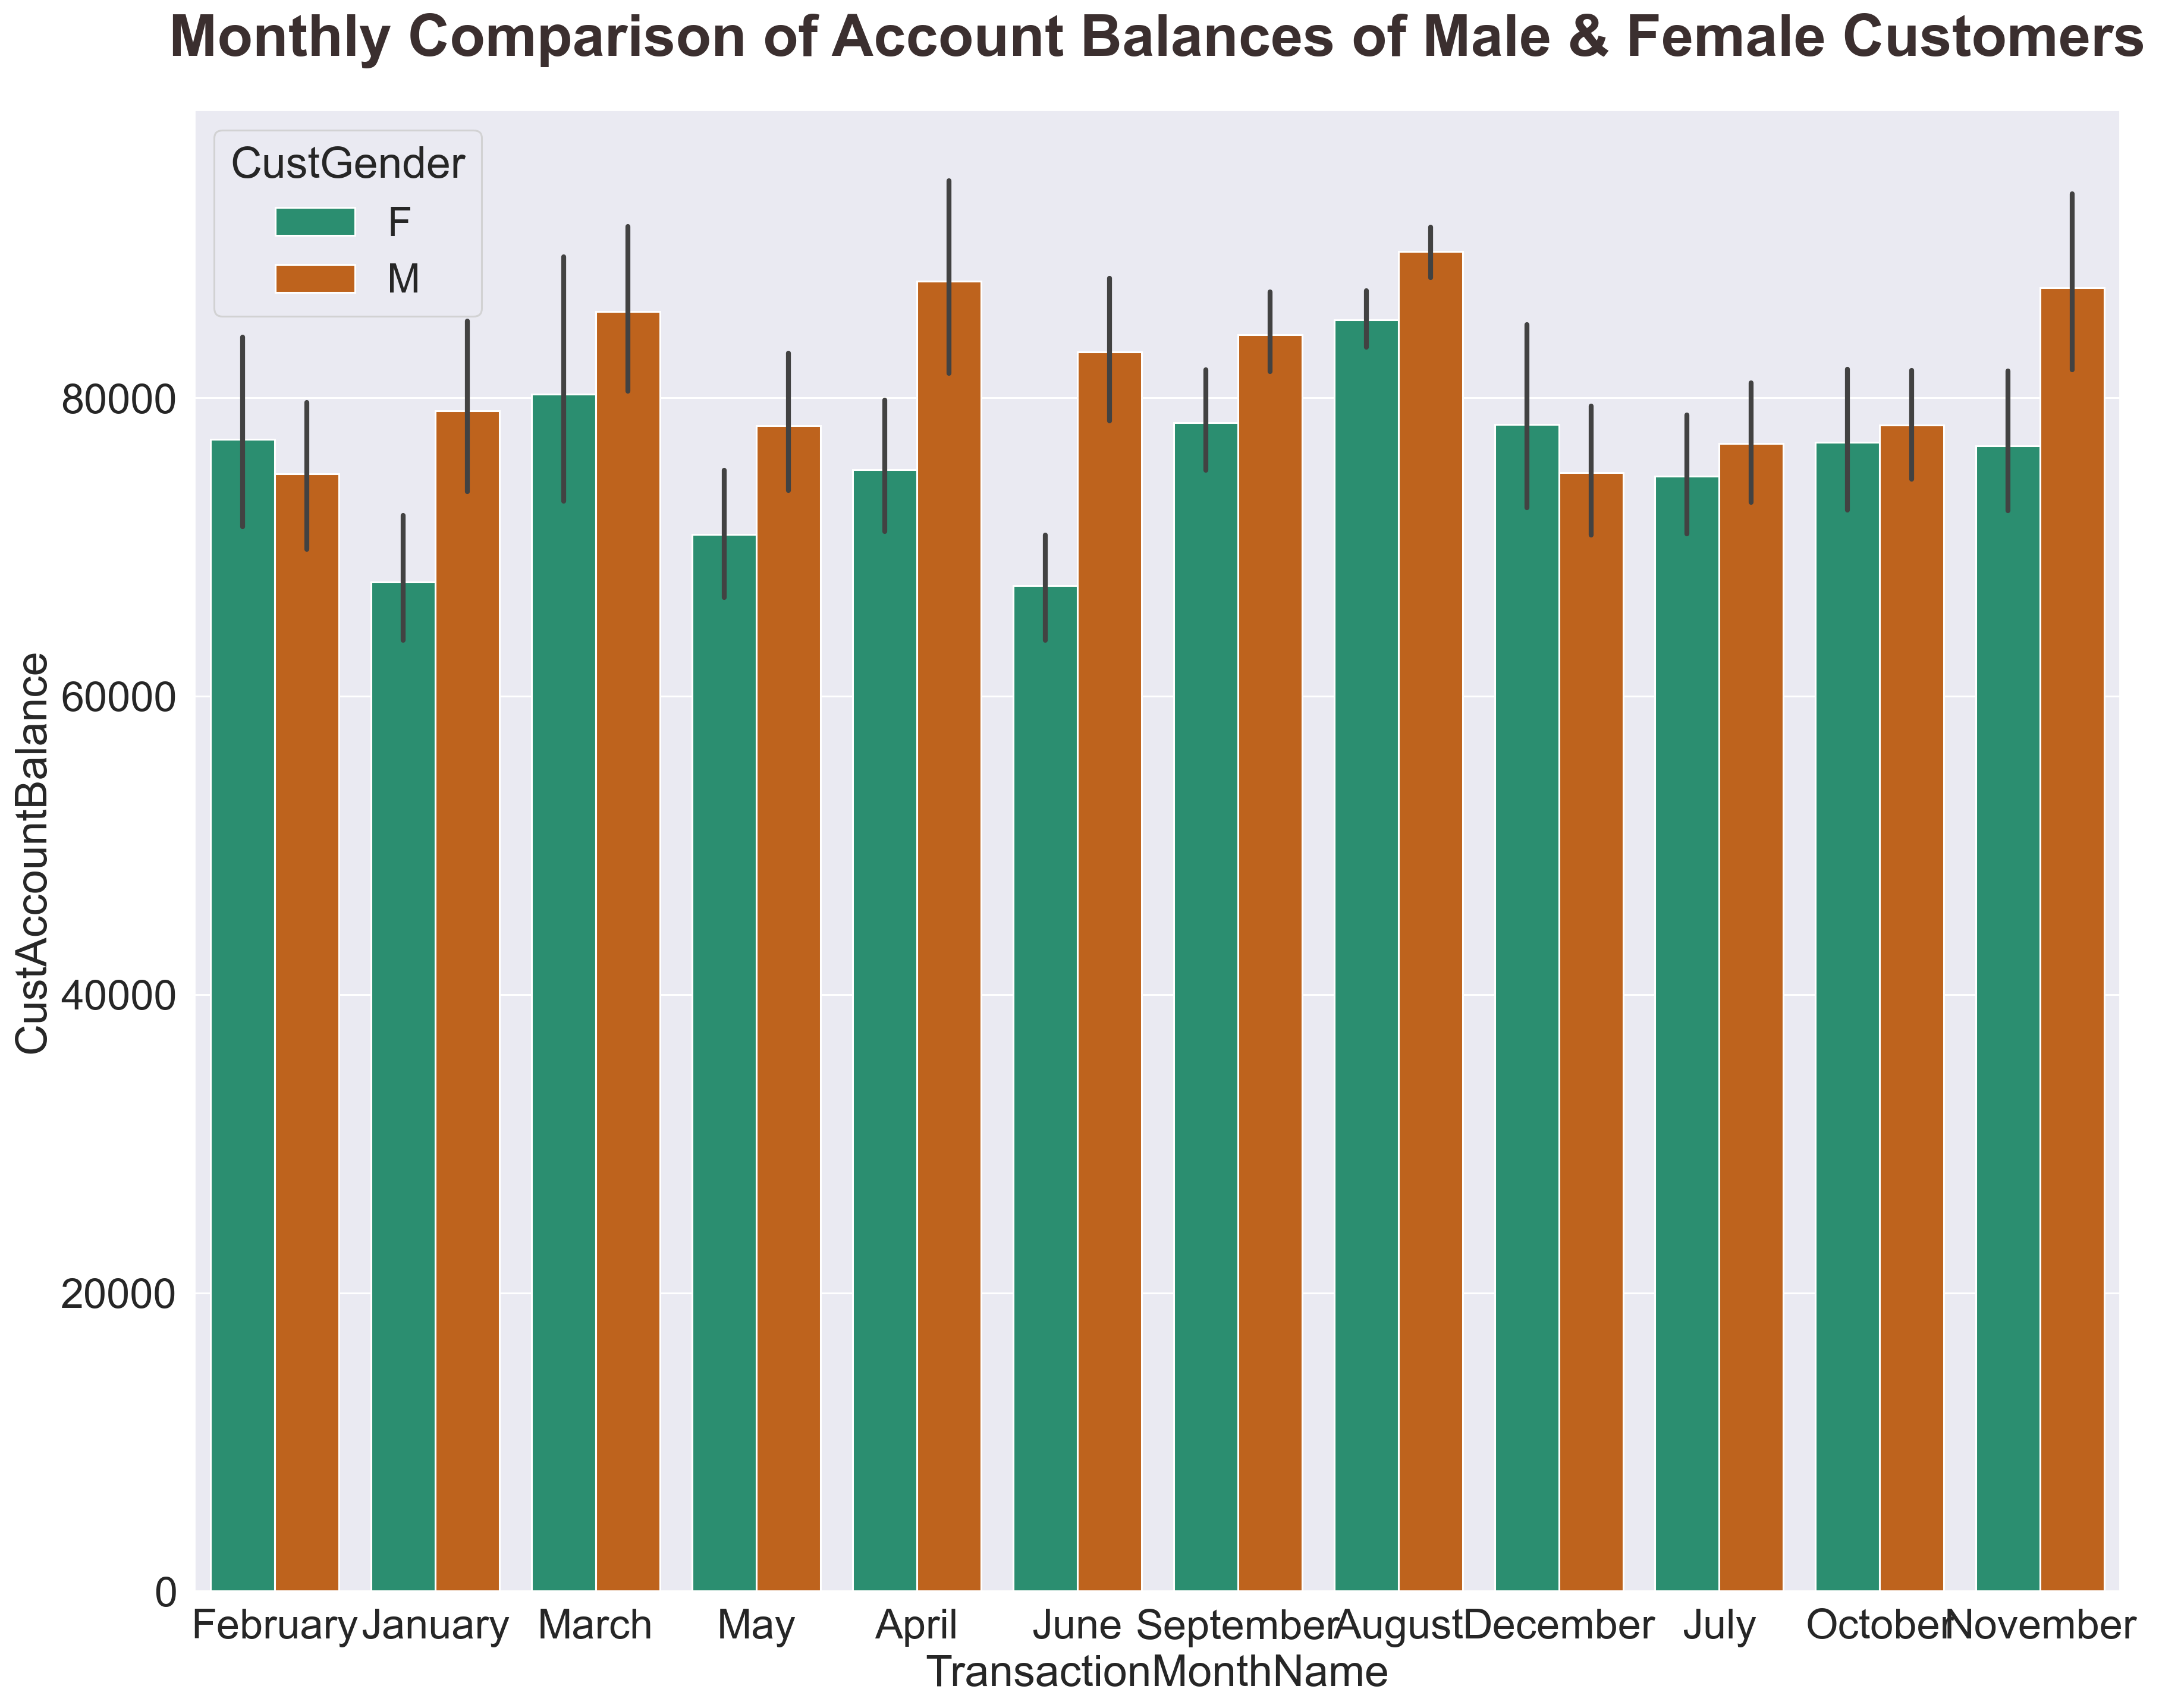

In [541]:
plt.figure(figsize=(19,15),dpi=220)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23)
sns.barplot(data=data,x='TransactionMonthName',y='CustAccountBalance',palette='Dark2',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='#3B2F2F',pad=30);

##### Male customers predominantly have greater account balances as compared to their female counterparts. 
##### Reason could be the fact that they generally make comparatively low value transactions than female customers.

<AxesSubplot:xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

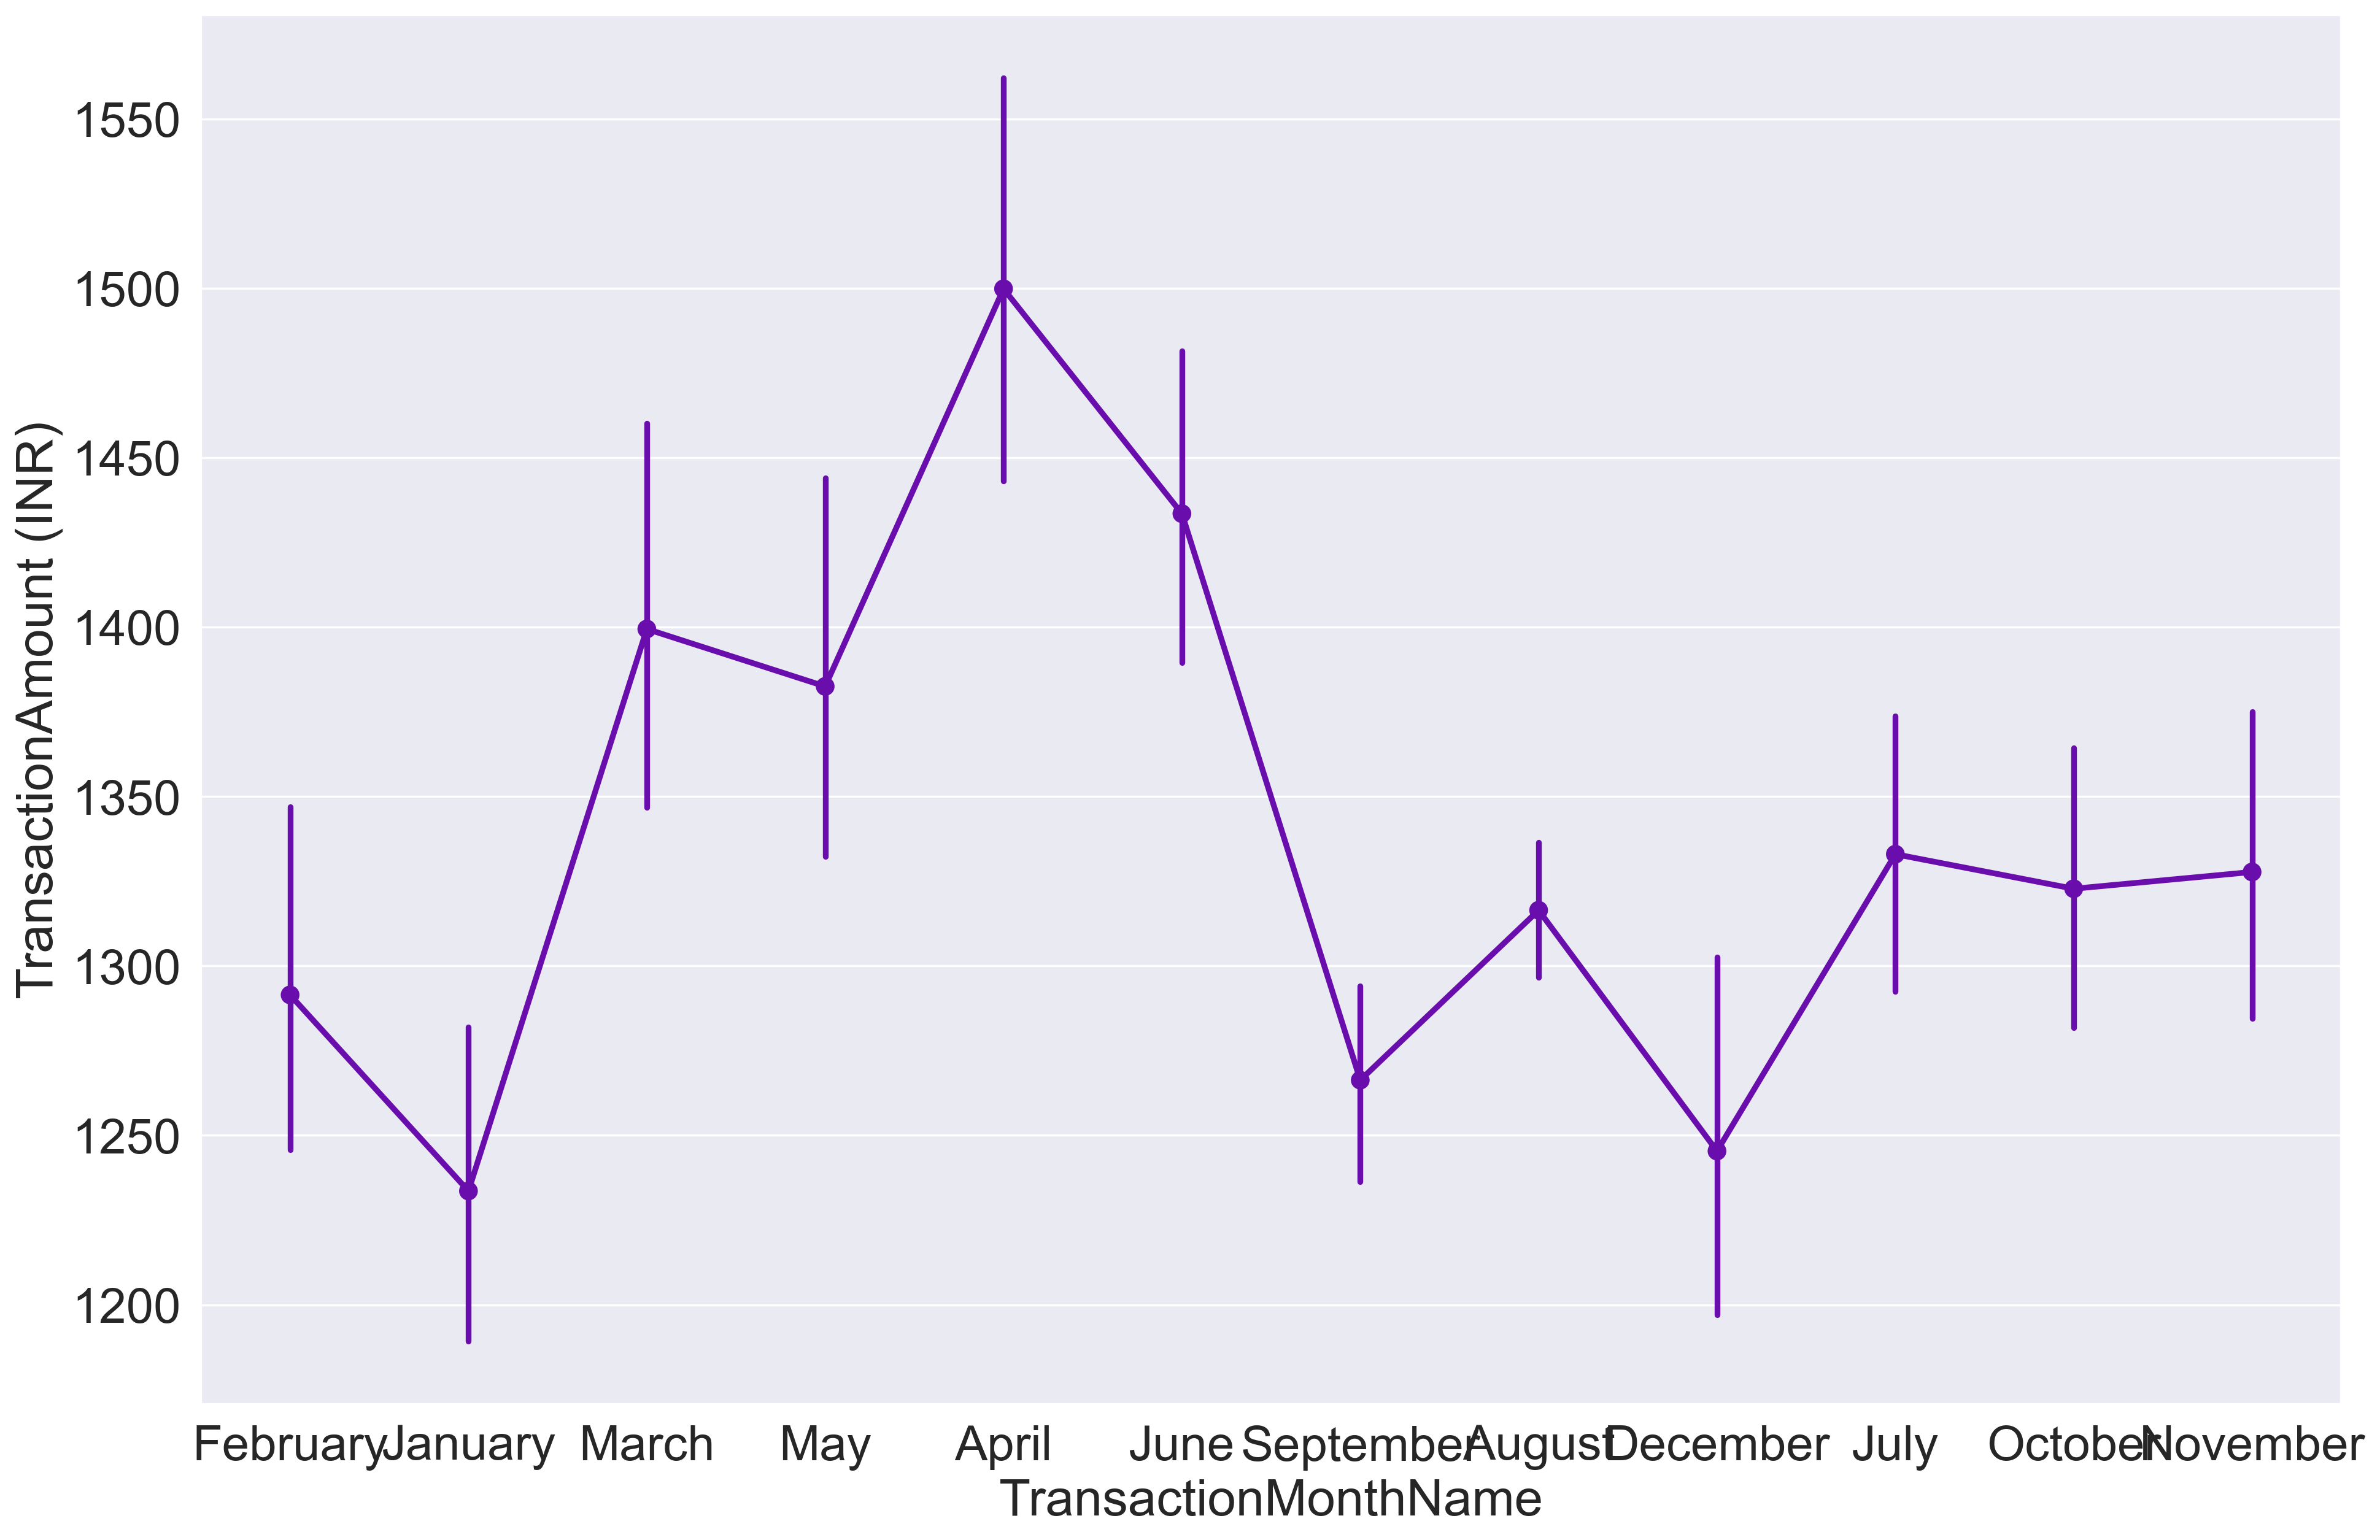

In [542]:
plt.figure(figsize=(18,12),dpi=250)
sns.pointplot(data=data,x='TransactionMonthName',y='TransactionAmount (INR)',color='#6A0DAD',)

##### Highest value transactions are performed during the summer months while least value transactions are made in the winter months.

<AxesSubplot:xlabel='TransactionMonthName', ylabel='CustAccountBalance'>

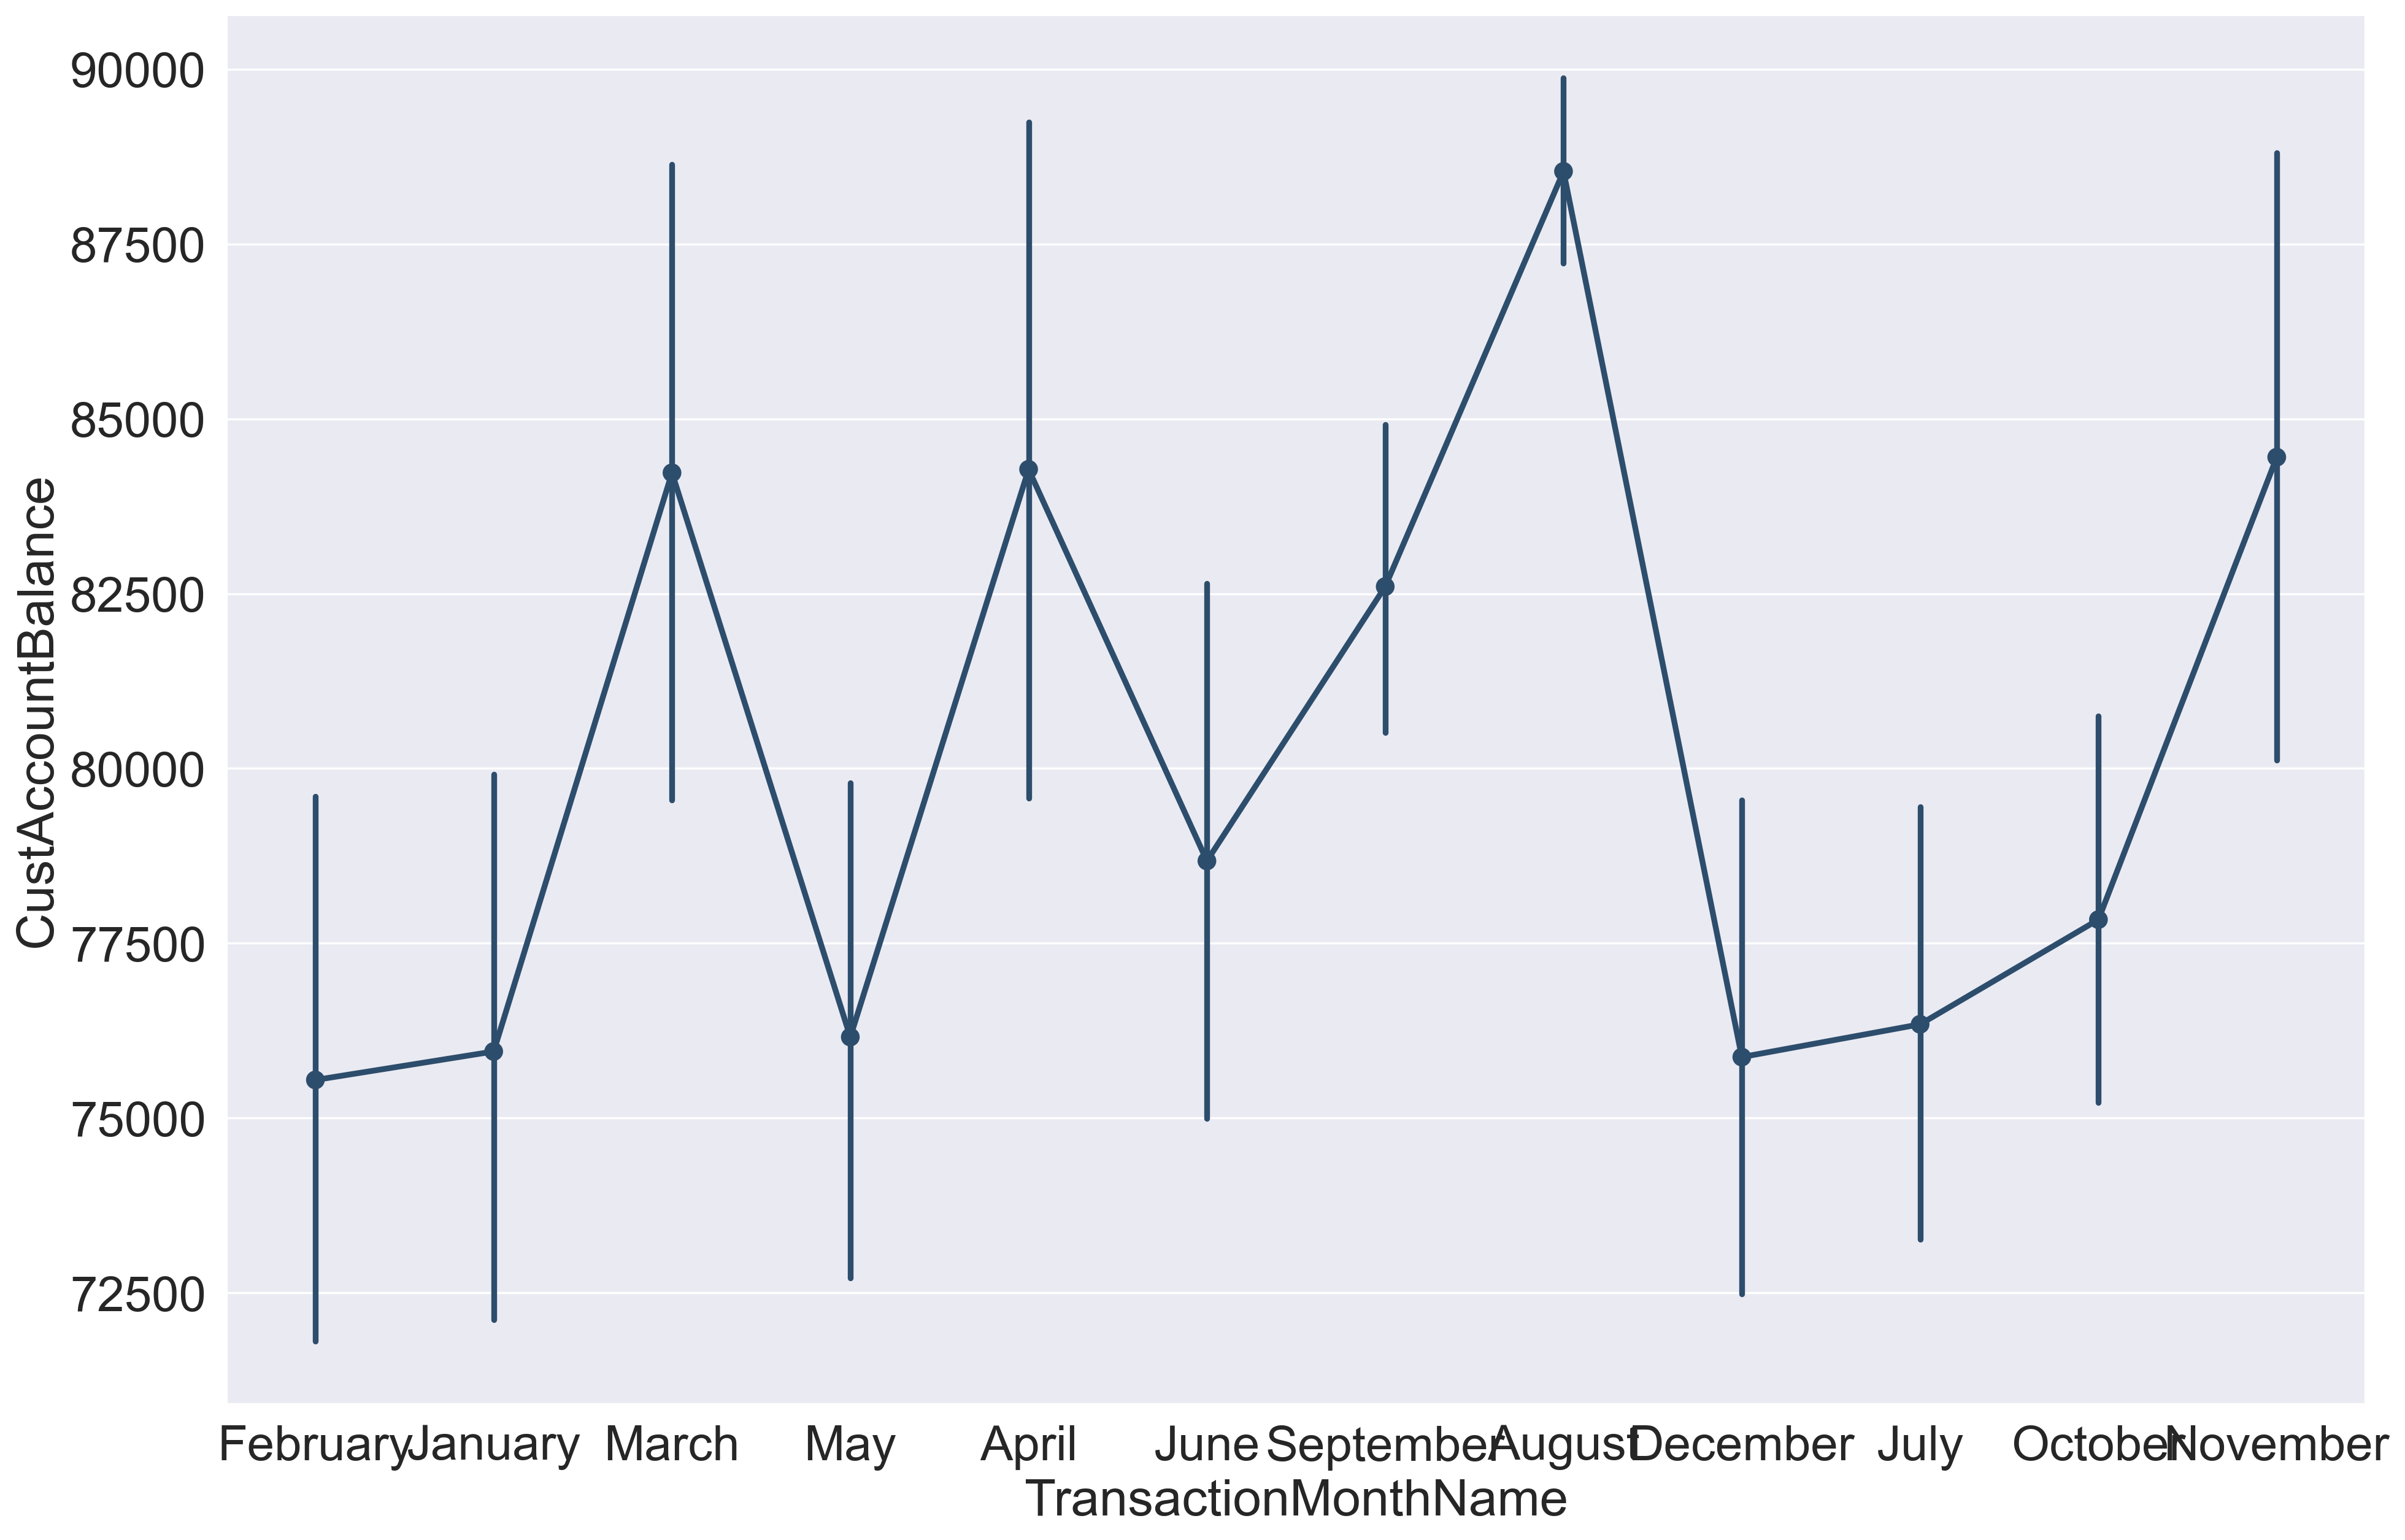

In [543]:
plt.figure(figsize=(18,12),dpi=250)
sns.pointplot(data=data,x='TransactionMonthName',y='CustAccountBalance',color='#2D4D6C')

##### Commonly, the account balances of customers are highest in the months of August and September whereas they are lowest in the months of July and December. 
##### In the festive months, the customer account balances drop significantly which makes sense as people usually expend more money during the festive season.

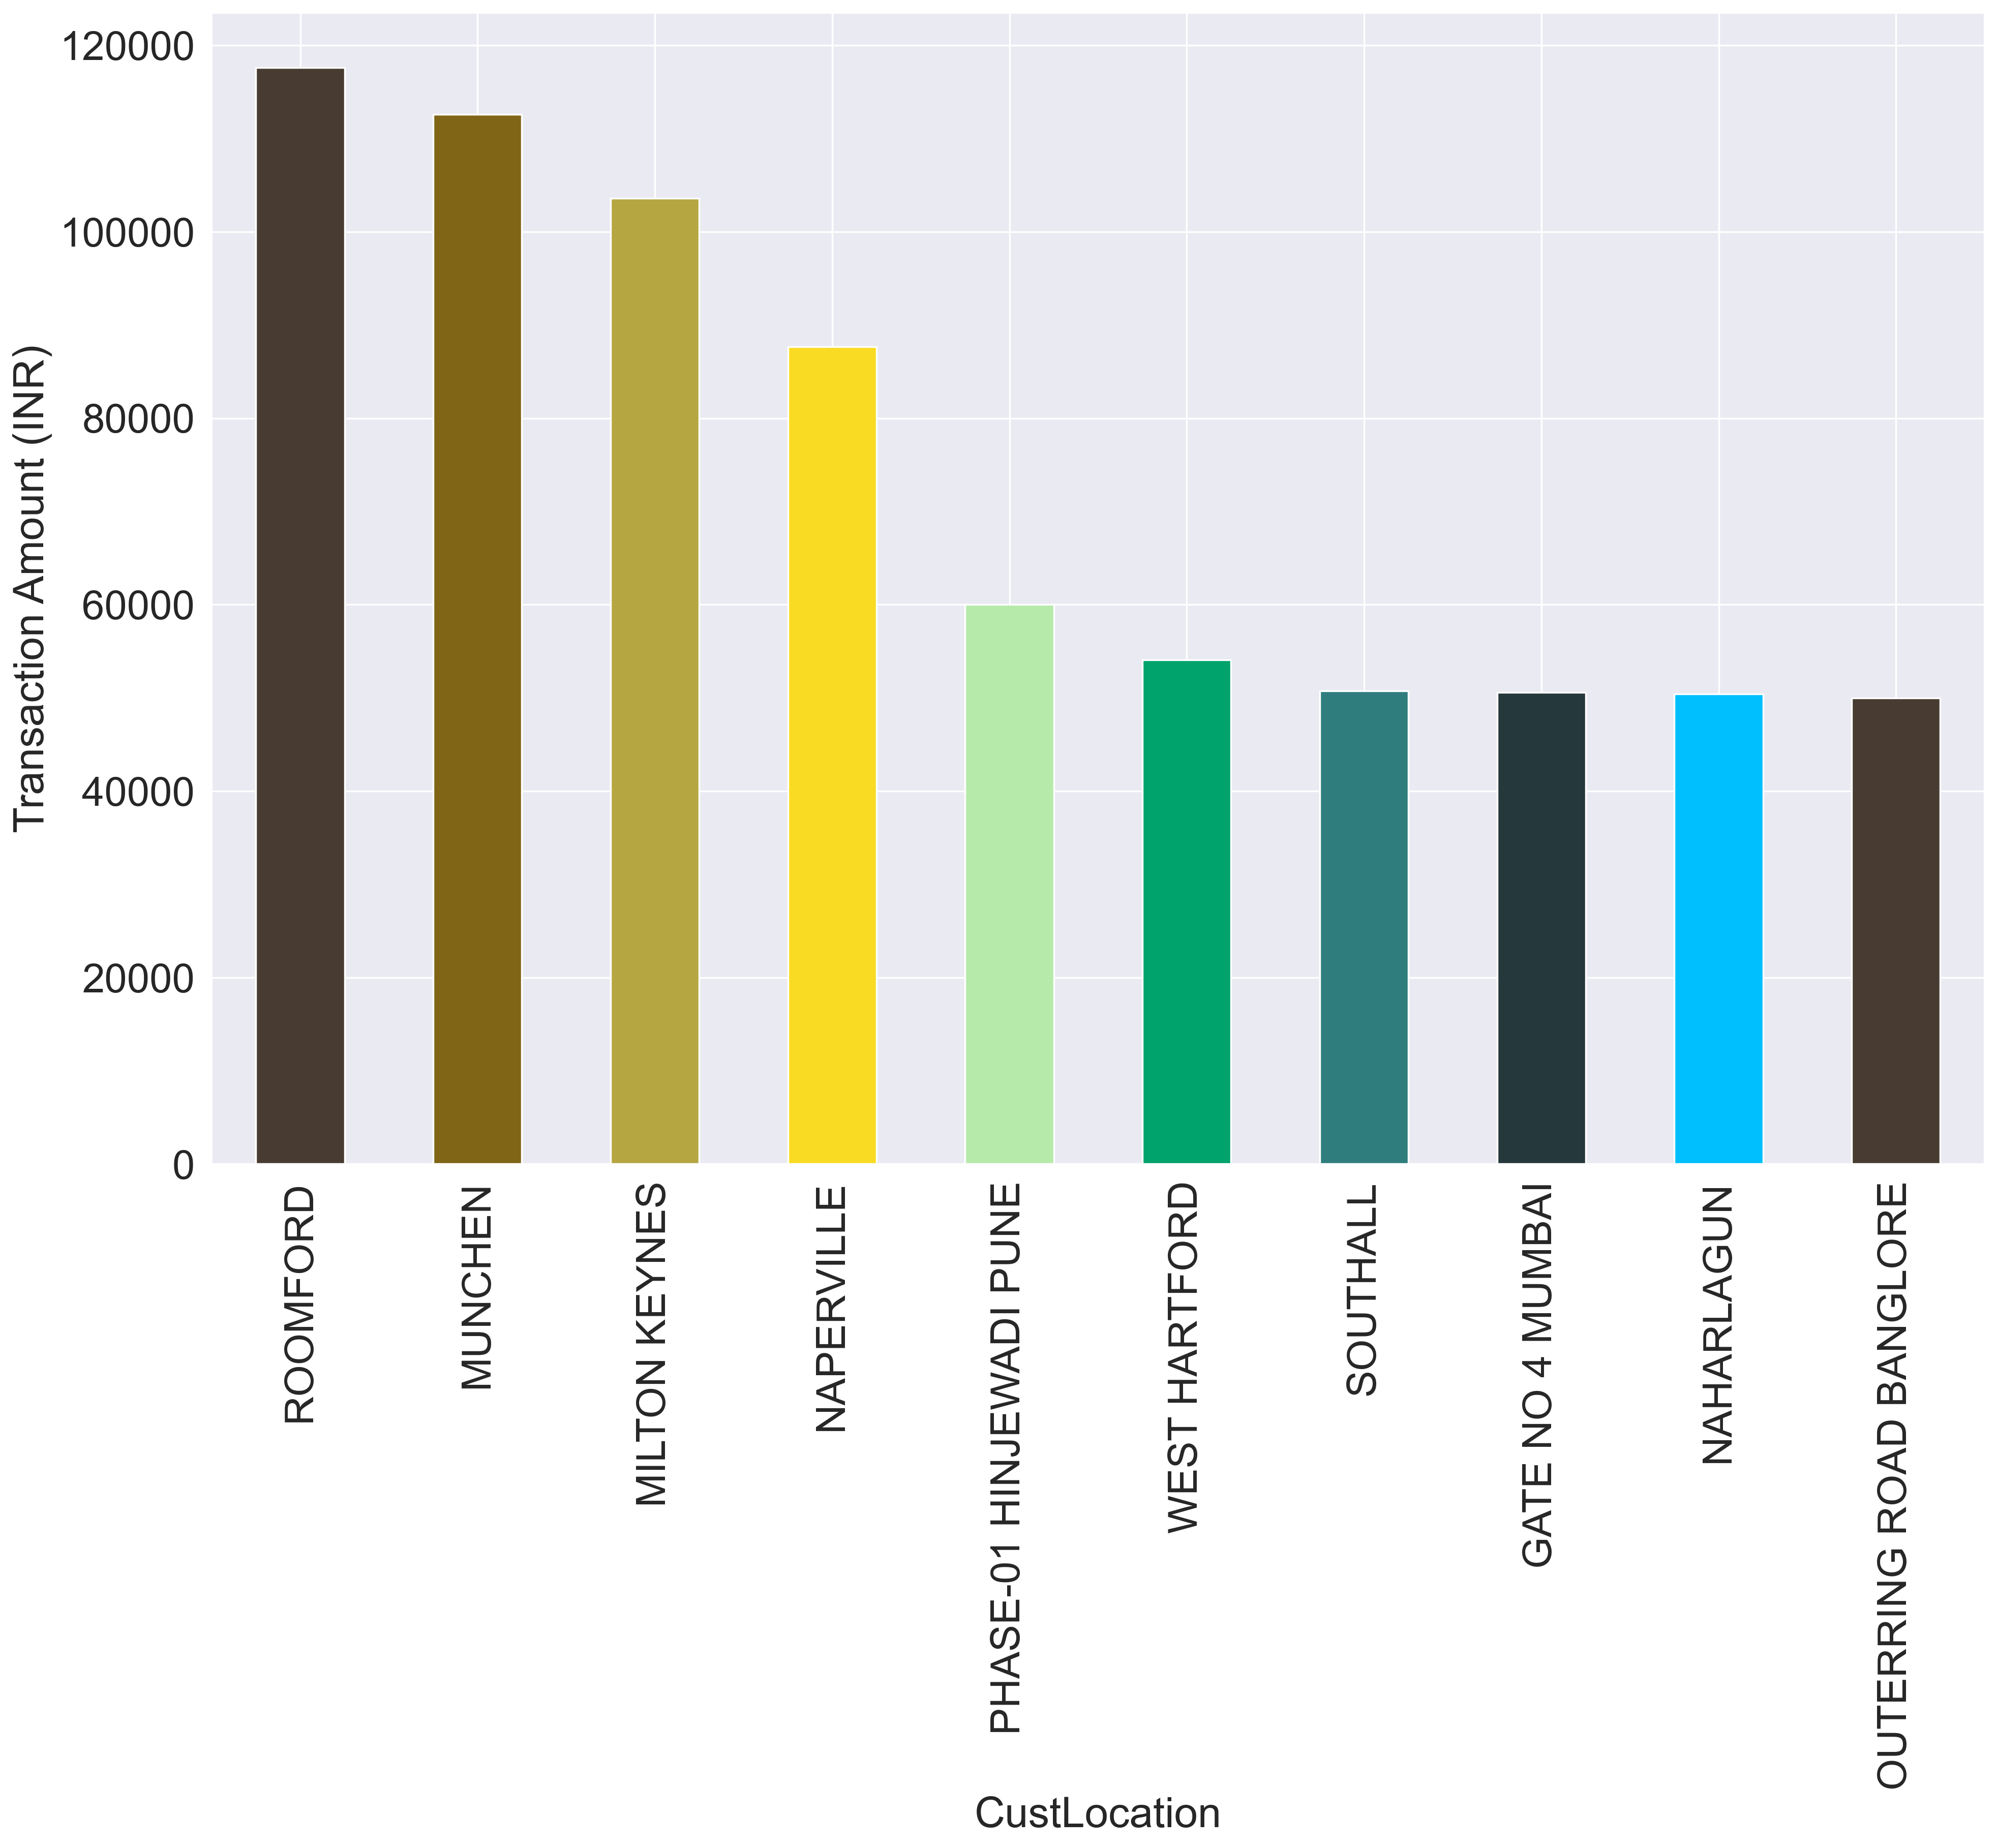

In [544]:
plt.figure(figsize=(18,12),dpi=250)
data.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar',
                                                                                                      color=["#483C32","#806517","#B5A642","#F9DB24","#B5EAAA","#00A36C","#307D7E","#25383C","#00BFFF"])
plt.ylabel('Transaction Amount (INR)');

##### Customers belonging to the Roomford bank branch in United Kingdom mostly perform the highest transactions which are closely followed by the bank branches in Palakkarai Trichy(Tamil Nadu, India) and Munchen in Germany.

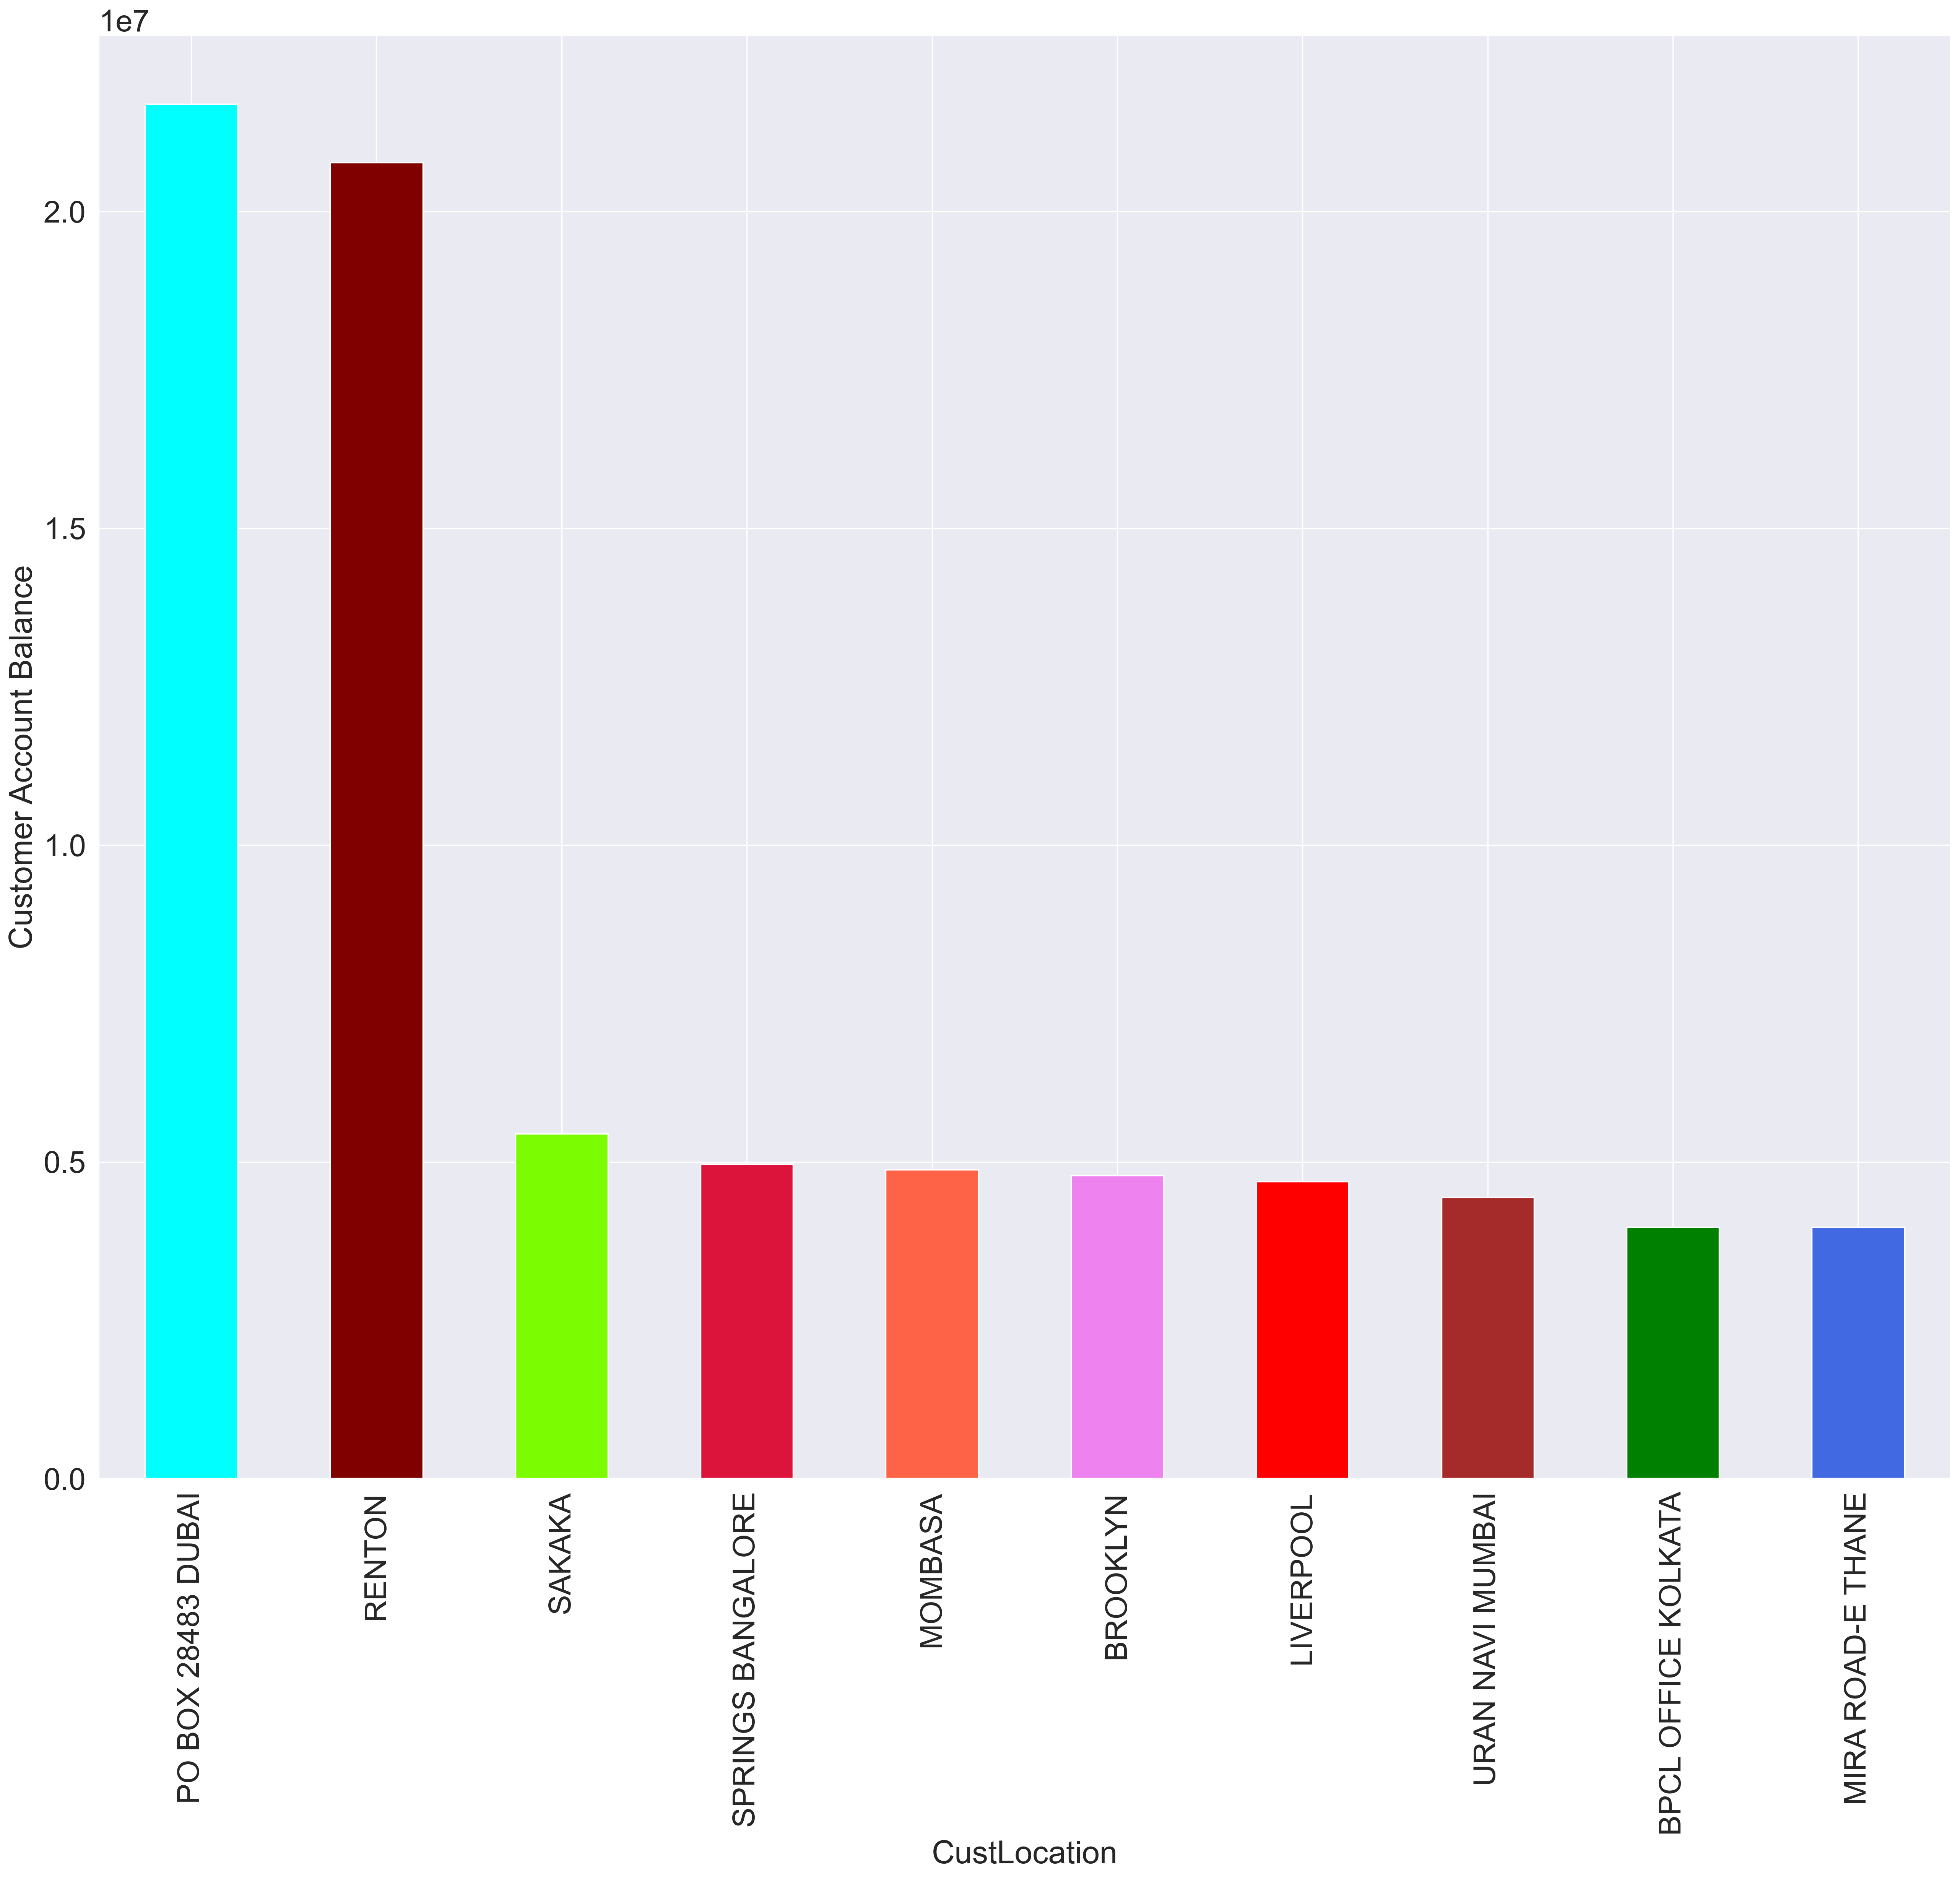

In [545]:
plt.figure(figsize=(25,20),dpi=250)
data.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['aqua','maroon','lawngreen','crimson','tomato','violet','red','brown','green','royalblue'])
plt.ylabel('Customer Account Balance');


##### Customers living in PO Box 28483 Dubai bank branch have the highest account balances among all customers.

<AxesSubplot:xlabel='Age', ylabel='CustAccountBalance'>

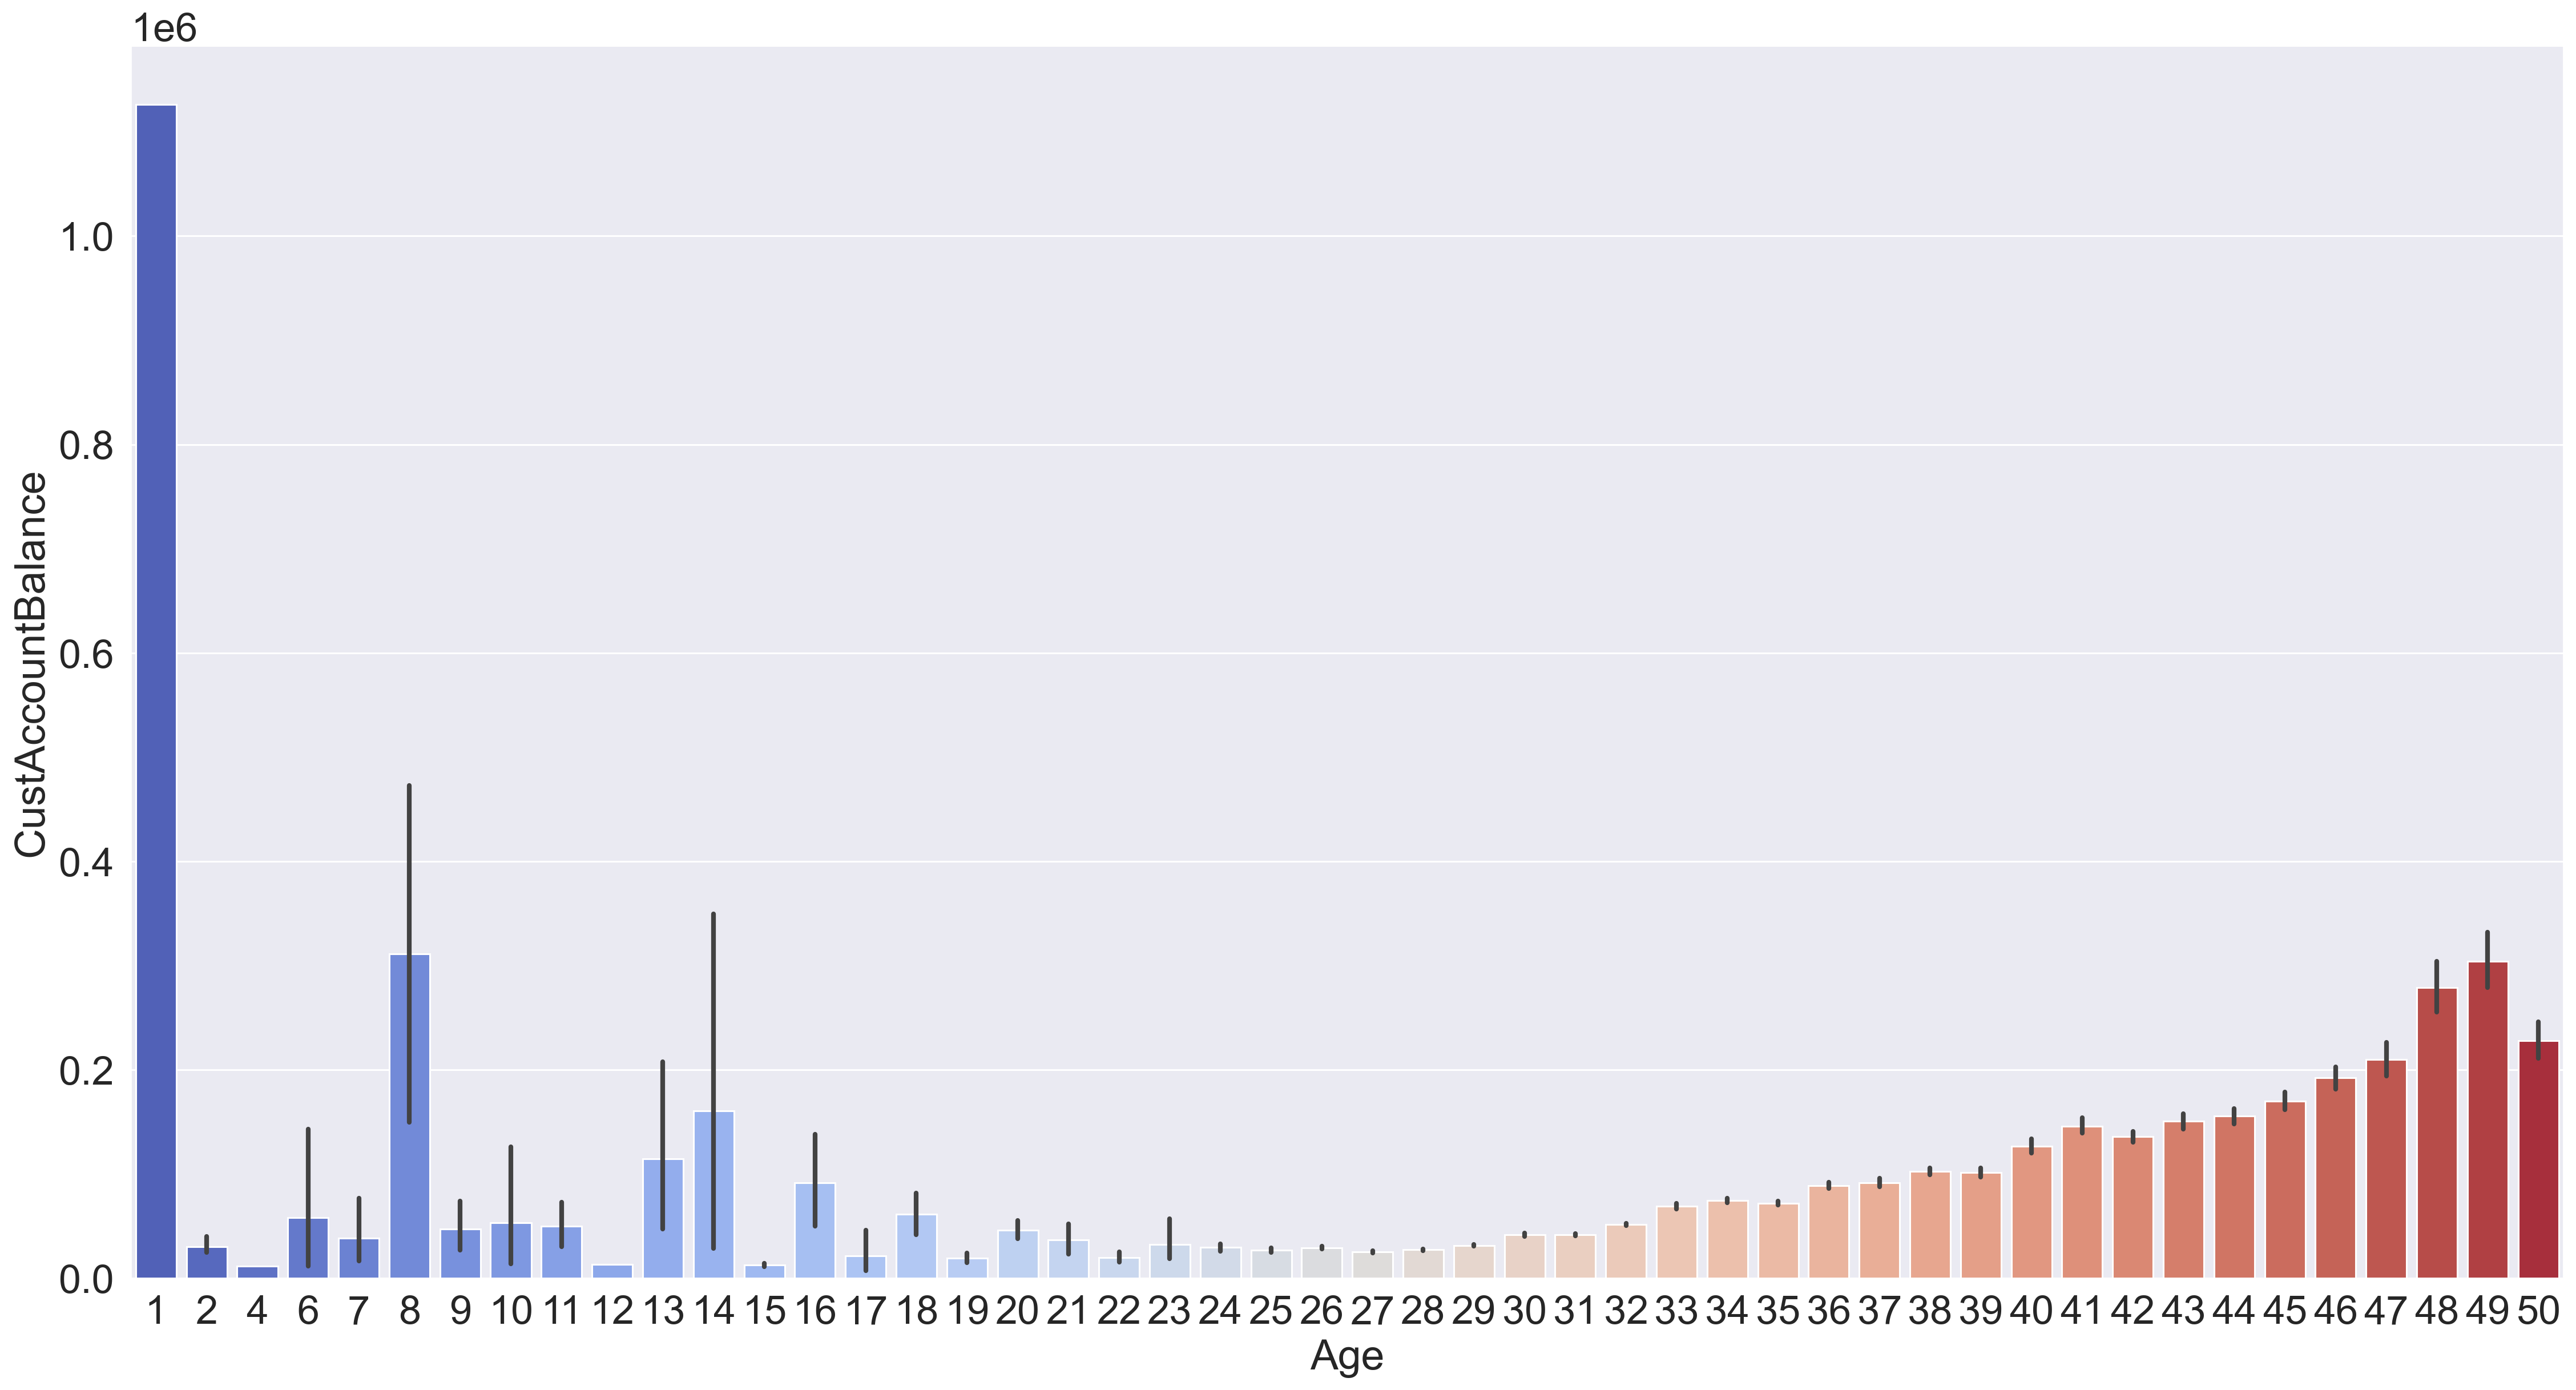

In [546]:
plt.figure(figsize=(25,13),dpi=220)
sns.barplot(data=data,x='Age',y='CustAccountBalance',palette='coolwarm')

##### In general, the account balances of customers rise abruptly with increase in their ages, attaining a peak by the old age of 50 years or more, although there are a few excepions to this matter. The account balances of younger adults in the age range of 19 to 22 years have higher account balances in comparison to their surrounding age groups.

<AxesSubplot:xlabel='Age', ylabel='TransactionAmount (INR)'>

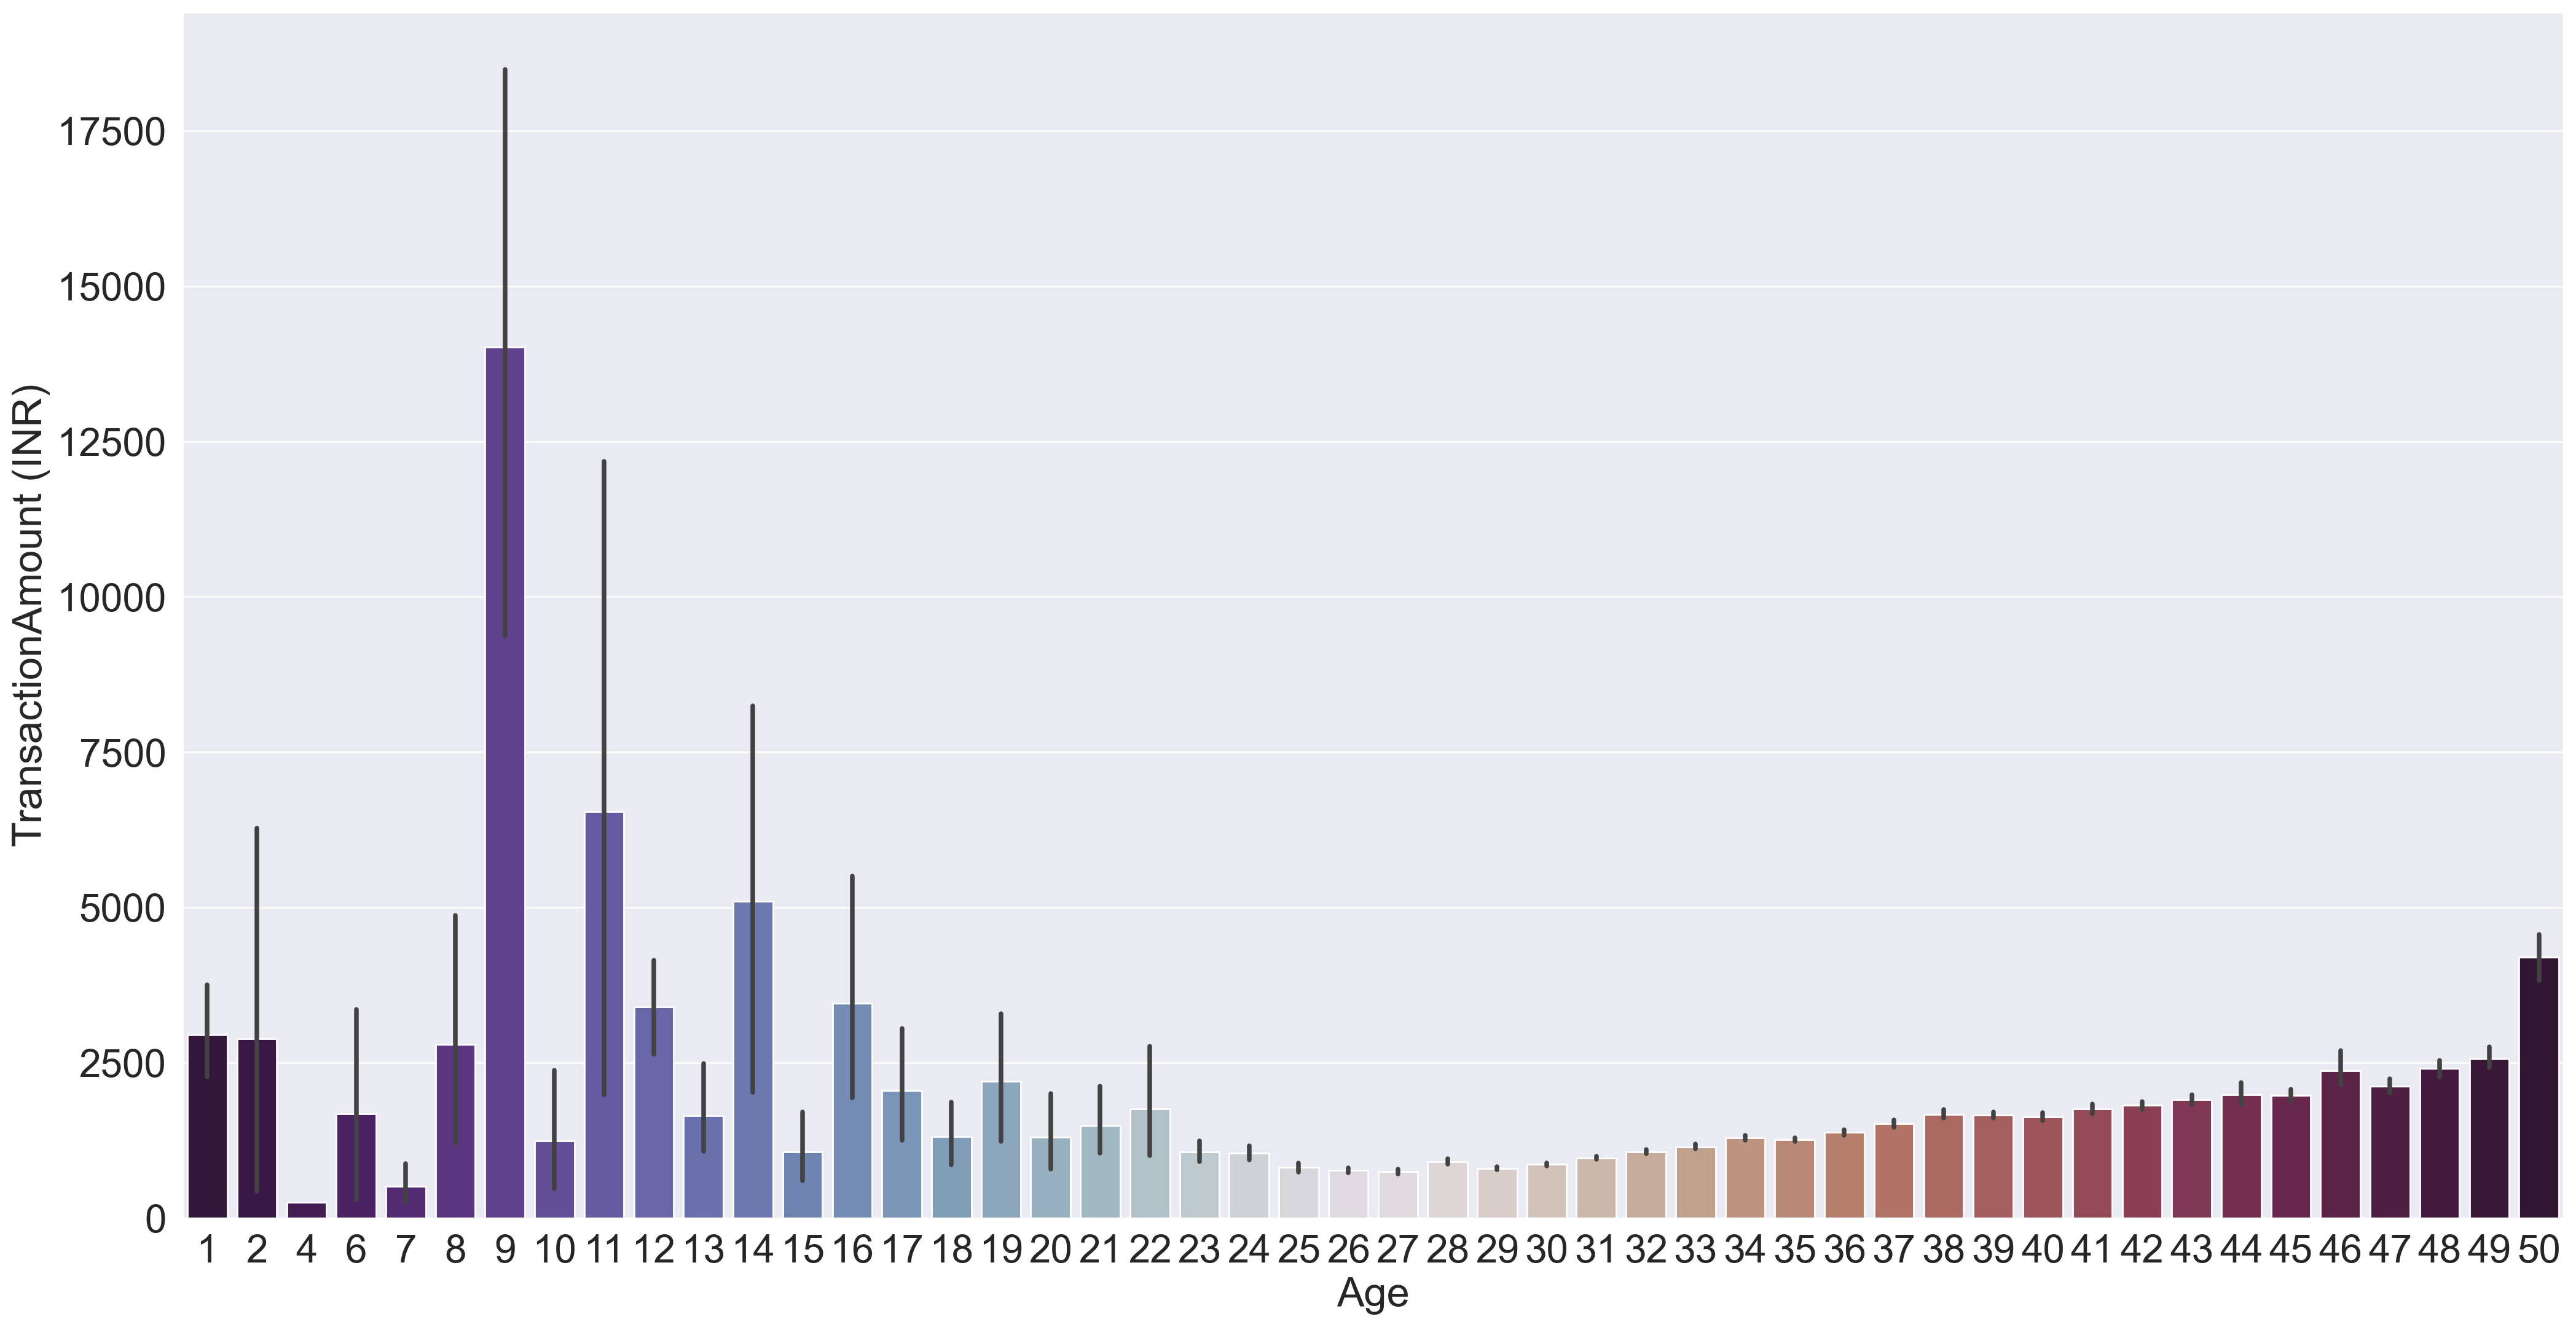

In [547]:
plt.figure(figsize=(25,13),dpi=200)
sns.barplot(data=data,x='Age',y='TransactionAmount (INR)',palette='twilight_shifted')

##### From above chart it is observed that,
##### Younger adult customers, in the age range of 19 to 24 years, perform very higher transactios than other age groups. This is most probably due to the reason that younger adults between the ages of 18 to 24 years have their own career aspirations to fulfil.
##### Middle age senior adults (24 to 33) and elderly customers make comparatively more extortionate transactions for managing their families and livelihoods

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'CustAccountBalance'),
  Text(1.5, 0, 'TransactionTime'),
  Text(2.5, 0, 'TransactionAmount (INR)'),
  Text(3.5, 0, 'Age'),
  Text(4.5, 0, 'TransactionMonth'),
  Text(5.5, 0, 'TransactionDay')])

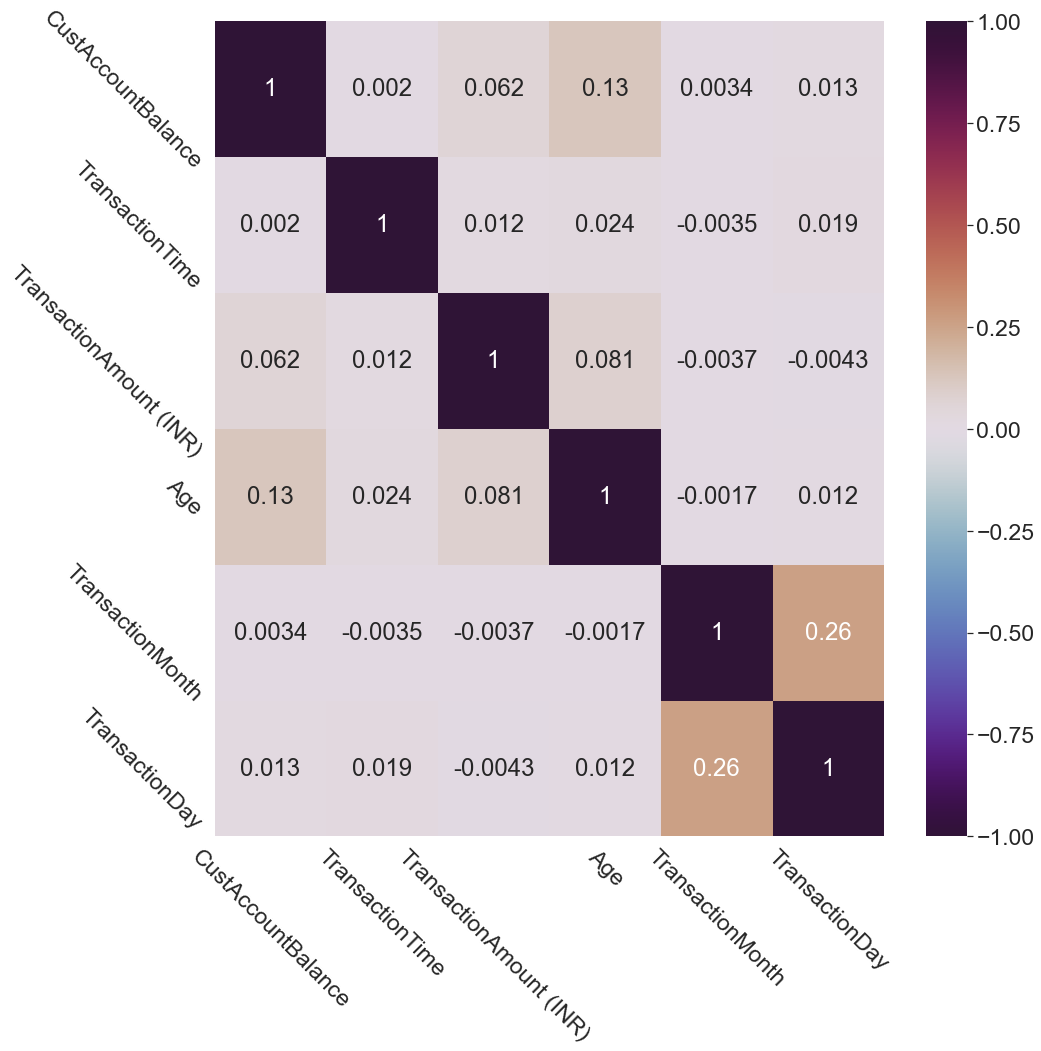

In [548]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,cmap='twilight_shifted',vmin=-1,vmax=1)
sns.set(font_scale=1.5)
plt.yticks(rotation=-45)
plt.xticks(rotation=-45)

In [549]:
sns.clustermap(data.corr(),figsize=(12,12),row_cluster=False)

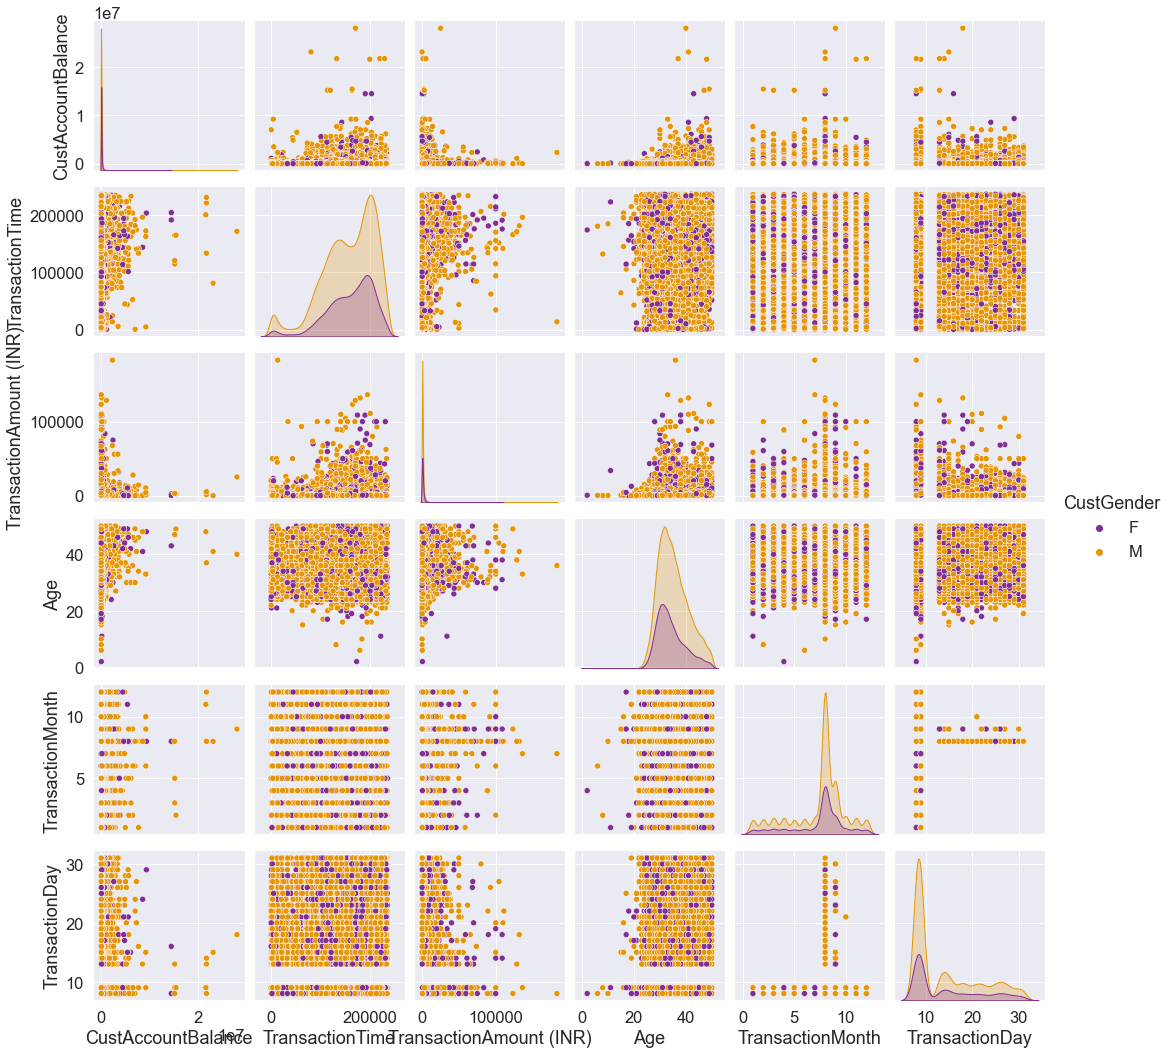

In [550]:
sns.pairplot(data.sample(n=50000),hue="CustGender",palette='CMRmap')

In [551]:
data.CustGender.replace(['F','M'],[0,1],inplace=True)
data.CustGender = data.CustGender.astype(np.int64)

### Categorical Encoding

In [552]:
encoder = LabelEncoder()
data.CustLocation = encoder.fit_transform(data.CustLocation)
data.CustLocation = data.CustLocation.astype(np.int64)

In [611]:
data.drop(['TransactionMonthName','TransactionDayName'],axis=1,inplace=True)

KeyError: "['TransactionMonthName', 'TransactionDayName'] not found in axis"

In [610]:
data.shape

(912457, 8)

### Feature Scaling

In [556]:
scaler = StandardScaler()
dummy=data[['CustGender','CustLocation','TransactionTime','Age','TransactionMonth','TransactionDay']].copy()

In [557]:
dummy.CustGender.astype(int)

0          0
2          0
3          0
4          0
5          0
          ..
1048562    1
1048563    1
1048564    1
1048565    1
1048566    1
Name: CustGender, Length: 912457, dtype: int32

In [558]:
scaled_data = scaler.fit_transform(dummy)
scaled_data = pd.DataFrame(scaled_data,columns=dummy.columns)
scaled_data.head()

CustGender  CustLocation  TransactionTime   Age  TransactionMonth  \
0       -1.62         -0.23            -0.28 -1.38             -2.02   
1       -1.62          0.49            -0.29 -1.73             -2.02   
2       -1.62          0.49            -0.29  2.31             -2.02   
3       -1.62          0.66             0.46 -0.15             -2.02   
4       -1.62         -0.27             0.32  2.66             -2.02   

   TransactionDay  
0           -0.88  
1           -0.88  
2           -0.88  
3           -0.88  
4           -0.88

In [559]:
scaled_data.shape

(912457, 6)

In [560]:
(data['TransactionAmount (INR)']+1).transform('log')

0         3.26
2         6.13
3         7.63
4         7.48
5         6.52
          ... 
1048562   6.68
1048563   6.13
1048564   6.65
1048565   6.91
1048566   7.06
Name: TransactionAmount (INR), Length: 912457, dtype: float64

In [561]:
scaled_data['TransactionAmount (INR)']=(data['TransactionAmount (INR)']+1).transform('log')

In [567]:
scaled_data['CustAccountBalance']=(data['CustAccountBalance']+1).transform('log')

In [568]:
scaled_data['Age']=(data['Age']+1).transform('log')

In [569]:
scaled_data['Age']=scaled_data['Age']=scaled_data['Age'].fillna(scaled_data.
                                                        groupby('CustLocation')['Age'].transform('mean'))

In [570]:
scaled_data['CustAccountBalance']=scaled_data['CustAccountBalance'].fillna(scaled_data.
                                                        groupby('CustLocation')['CustAccountBalance'].transform('mean'))

In [571]:
scaled_data['TransactionAmount (INR)']=scaled_data['TransactionAmount (INR)'].fillna(scaled_data.
                                                        groupby('CustLocation')['TransactionAmount (INR)'].transform('mean'))

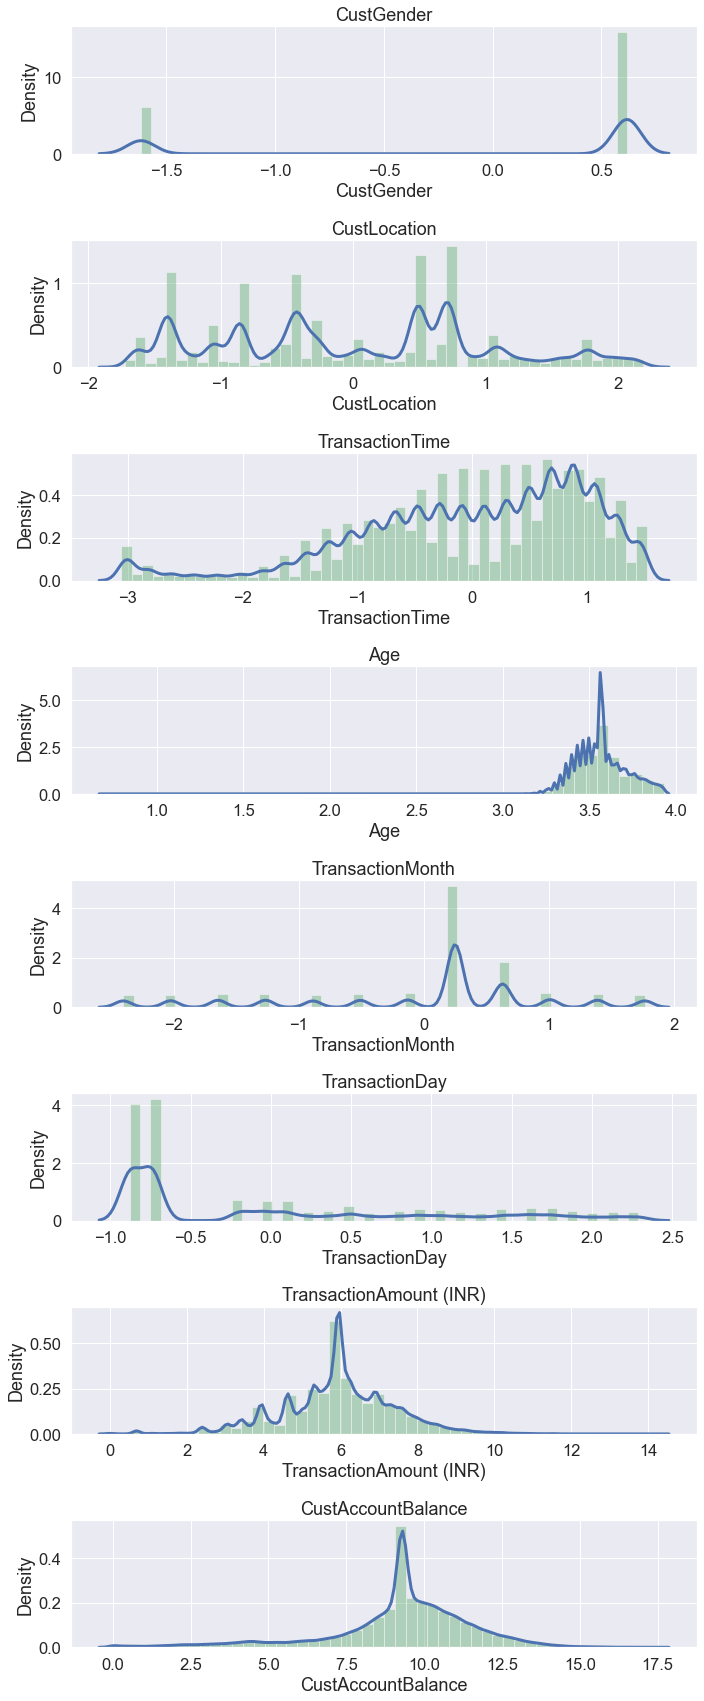

In [572]:
plt.figure(figsize=(10,50))
for i in range(len(scaled_data.columns)):
    plt.subplot(17, 1, i+1)
    sns.distplot(scaled_data[scaled_data.columns[i]], kde_kws={"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"})
    plt.title(scaled_data.columns[i])

plt.tight_layout()

In [573]:
scaled_data=scaled_data.dropna()

In [574]:
scaled_data.columns

Index(['CustGender', 'CustLocation', 'TransactionTime', 'Age',
       'TransactionMonth', 'TransactionDay', 'TransactionAmount (INR)',
       'CustAccountBalance'],
      dtype='object')

In [575]:
scaled_data.isna().sum()

CustGender                 0
CustLocation               0
TransactionTime            0
Age                        0
TransactionMonth           0
TransactionDay             0
TransactionAmount (INR)    0
CustAccountBalance         0
dtype: int64

In [576]:
New_scaled_data = scaler.fit_transform(scaled_data)
New_scaled_data = pd.DataFrame(New_scaled_data,columns=scaled_data.columns)
New_scaled_data.head()

CustGender  CustLocation  TransactionTime   Age  TransactionMonth  \
0       -1.62         -0.23            -0.28 -1.61             -2.02   
1       -1.62          0.49            -0.29 -0.00             -2.02   
2       -1.62          0.49            -0.29 -2.11             -2.02   
3       -1.62          0.66             0.46  2.22             -2.02   
4       -1.62         -0.27             0.32 -0.08             -2.02   

   TransactionDay  TransactionAmount (INR)  CustAccountBalance  
0           -0.88                    -1.84                0.22  
1           -0.88                    -0.00               -0.00  
2           -0.88                     0.13                0.22  
3           -0.88                     1.15                1.91  
4           -0.88                     1.04               -0.21

<AxesSubplot:xlabel='TransactionAmount (INR)', ylabel='Count'>

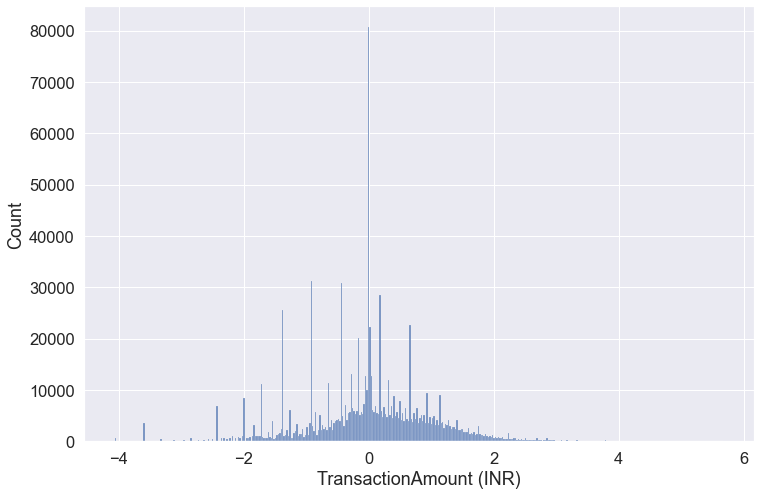

In [577]:
sns.histplot(New_scaled_data['TransactionAmount (INR)'])

## Unsupervised Machine Learning

In [578]:
temp = New_scaled_data.sample(n=50000)

### K Means Clustering

In [579]:
base_kmeans = KMeans(random_state=141)
base_kmeans.fit(temp)

KMeans(random_state=141)

In [580]:
labels = set(base_kmeans.labels_)
labels

{0, 1, 2, 3, 4, 5, 6, 7}

In [581]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 12.1%


In [582]:
for i in range(1,11):
    for init in ['k-means++','random']:
        for algo in ['auto','full','elkan']:
            kmeans = KMeans(n_clusters=i,init=init,algorithm=algo,random_state=101)
            kmeans.fit(temp)
            print("Number of Clusters: {}".format(i))
            print("Initialization Algorithm: {}".format(init))
            print("Algorithm: {}".format(algo))
            print("Sum of Squared Distance: %d" % kmeans.inertia_)
            print('-----------------')

Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: auto
Sum of Squared Distance: 400314
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: full
Sum of Squared Distance: 400314
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 400314
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: auto
Sum of Squared Distance: 400314
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: full
Sum of Squared Distance: 400314
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 400314
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: auto
Sum of Squared Distance: 350359
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: full
Sum of Squared Distance: 350359
-----------------
Number of Clust

In [583]:
optimized_kmeans = KMeans(n_clusters=10,init='k-means++',algorithm='elkan',random_state=141)
optimized_kmeans.fit(temp)
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 13.55%


In [584]:
print("Estimated number of clusters:", len(set(optimized_kmeans.labels_)), set(optimized_kmeans.labels_))
print("Estimated number of noise points:", list(optimized_kmeans.labels_).count(-1))

Estimated number of clusters: 10 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Estimated number of noise points: 0


<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

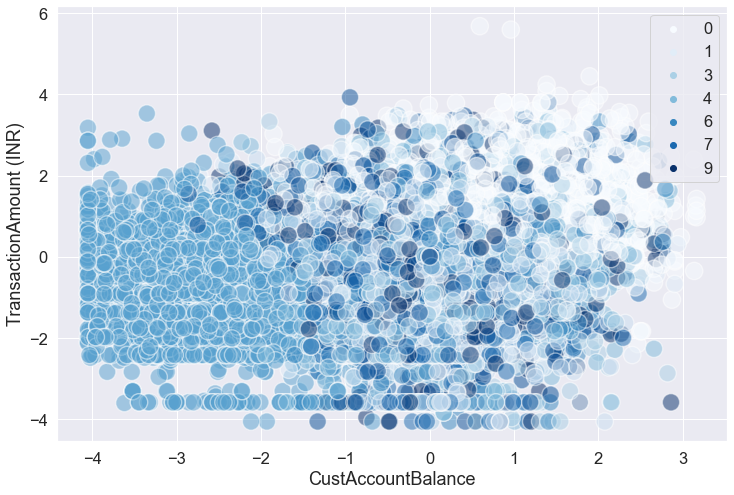

In [585]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_kmeans.labels_,s=300,alpha=0.5,palette='Blues')

In [586]:
ce = clusteval(cluster='kmeans',savemem=True,verbose=4)
results = ce.fit(np.reshape(np.ravel(temp.sample(5000)),(-1,1)))
cluster_labels = results['labx']


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.
[clusteval] >Save memory enabled for kmeans with evaluation silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [05:52<00:00, 15.33s/it]

[clusteval] >Optimal number clusters detected: [21].
[clusteval] >Fin.


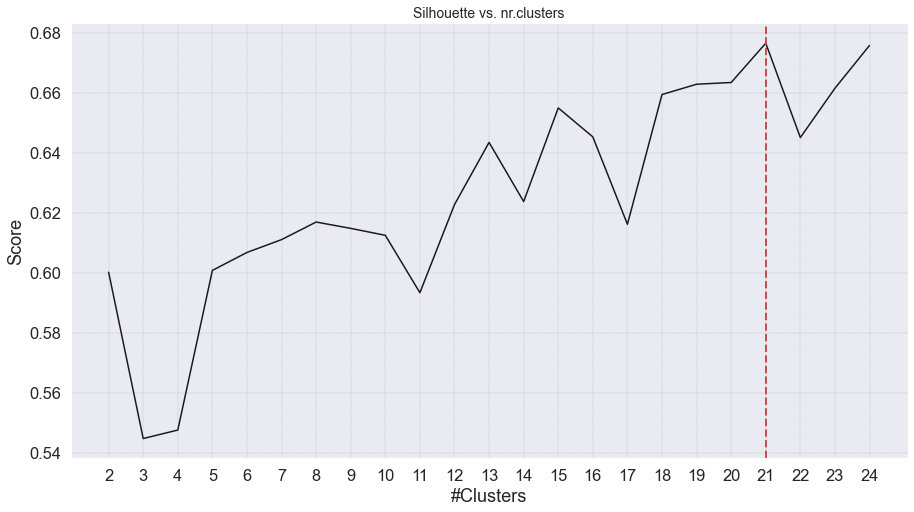

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Silhouette vs. nr.clusters'}, xlabel='#Clusters', ylabel='Score'>)

In [587]:
ce.plot()

#### Hierarchical Clustering

In [588]:
mmscaler = MinMaxScaler()
minmax_scaled_data = mmscaler.fit_transform(New_scaled_data)
minmax_scaled_data = pd.DataFrame(minmax_scaled_data,columns=New_scaled_data.columns)
minmax_scaled_data.head()

CustGender  CustLocation  TransactionTime  Age  TransactionMonth  \
0        0.00          0.38             0.61 0.81              0.09   
1        0.00          0.57             0.60 0.89              0.09   
2        0.00          0.57             0.60 0.79              0.09   
3        0.00          0.61             0.77 0.99              0.09   
4        0.00          0.37             0.74 0.88              0.09   

   TransactionDay  TransactionAmount (INR)  CustAccountBalance  
0            0.00                     0.23                0.56  
1            0.00                     0.42                0.53  
2            0.00                     0.43                0.56  
3            0.00                     0.54                0.78  
4            0.00                     0.52                0.51

In [589]:
temp2 = minmax_scaled_data.sample(n=20000)

In [590]:
base_hc = AgglomerativeClustering()
base_hc.fit(temp2)

AgglomerativeClustering()

In [591]:
print("Estimated number of clusters:", set(base_hc.labels_))

Estimated number of clusters: {0, 1}


In [592]:
print("Estimated number of noise points:", list(base_hc.labels_).count(-1))

Estimated number of noise points: 0


In [593]:
print("Silhouette Score:",str(np.round(silhouette_score(temp2,base_hc.labels_)*100,2)) + '%')

Silhouette Score: 41.47%


<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

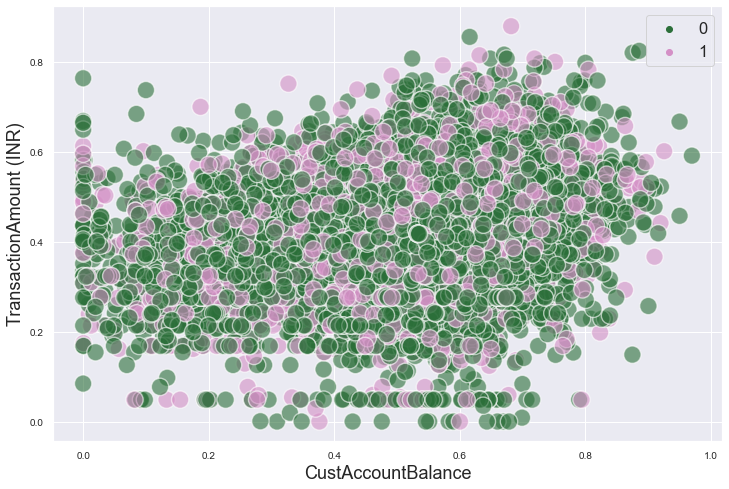

In [594]:
sns.scatterplot(temp2['CustAccountBalance'],temp2['TransactionAmount (INR)']
                ,hue=base_hc.labels_,s=300,alpha=0.6,palette='cubehelix')

In [595]:
temp2_samp = temp2.sample(500)
ce = clusteval(verbose=4)
results = ce.fit(np.reshape(np.ravel(temp2_samp),(-1,1)))
results


[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.74it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [23].
[clusteval] >Fin.


{'evaluate': 'silhouette',
 'score':     clusters  score
 0          2   0.54
 1          3   0.58
 2          4   0.64
 3          5   0.62
 4          6   0.59
 5          7   0.61
 6          8   0.63
 7          9   0.63
 8         10   0.61
 9         11   0.62
 10        12   0.62
 11        13   0.62
 12        14   0.62
 13        15   0.63
 14        16   0.63
 15        17   0.64
 16        18   0.65
 17        19   0.65
 18        20   0.66
 19        21   0.67
 20        22   0.67
 21        23   0.67
 22        24   0.67,
 'labx': array([ 0,  8,  2, ...,  7, 16, 14], dtype=int32),
 'fig': {'silscores': array([0.53596172, 0.58460306, 0.63718231, 0.62363461, 0.58669855,
         0.61419224, 0.63381154, 0.62900487, 0.61328977, 0.61691357,
         0.61561214, 0.61993502, 0.62347553, 0.62779309, 0.62716565,
         0.64232974, 0.64779901, 0.65445948, 0.66098855, 0.66728491,
         0.66943259, 0.67319225, 0.67279349]),
  'sillclust': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,

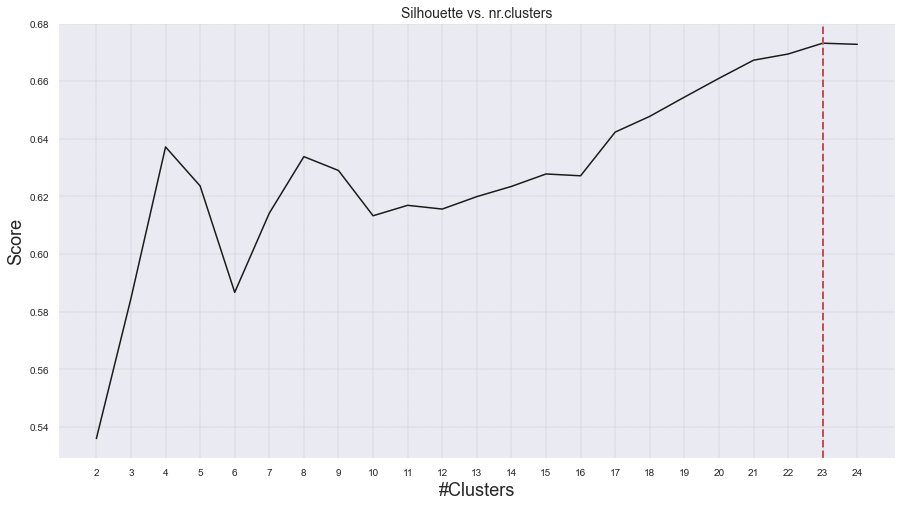

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Silhouette vs. nr.clusters'}, xlabel='#Clusters', ylabel='Score'>)

In [596]:
ce.plot()

#### Prinicipal Component Analysis

In [597]:
Temp = New_scaled_data.sample(10000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(Temp)
pca_components = pd.DataFrame(pca_components,columns=['PC1','PC2'])
pca_components.head()

PC1   PC2
0  0.62  2.02
1  2.93  1.56
2  0.87 -1.59
3 -0.54 -0.07
4 -1.55 -0.15

In [598]:
base_spectral = SpectralClustering(random_state=41)

In [599]:
base_spectral.fit(pca_components)

SpectralClustering(random_state=41)

In [600]:
print("Estimated number of clusters:",len(set(base_spectral.labels_)))
print("Clusters:",set(base_spectral.labels_))

Estimated number of clusters: 8
Clusters: {0, 1, 2, 3, 4, 5, 6, 7}


In [601]:
pca_components['Cluster'] = base_spectral.labels_
print("Silhouette Score:",str(np.round(silhouette_score(pca_components,pca_components.Cluster)*100,2)) + '%')

Silhouette Score: 41.63%


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

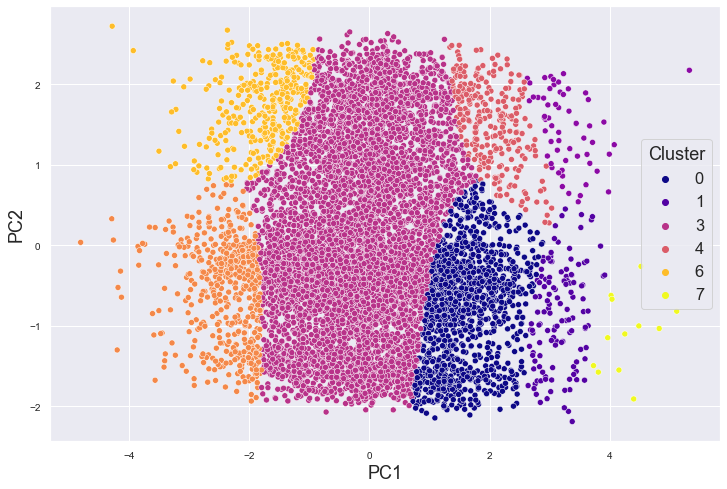

In [602]:
sns.scatterplot(pca_components['PC1'],pca_components['PC2'],hue=pca_components['Cluster'],palette='plasma')

<AxesSubplot:xlabel='Cluster'>

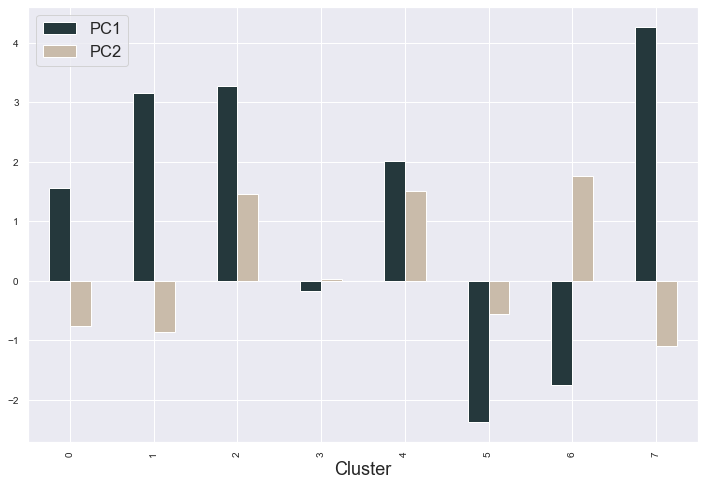

In [633]:
pca_components.groupby('Cluster')[['PC1','PC2']].mean().plot(kind='bar',color=['#25383C','#C9BBAA'])

On Original Feature Space

In [604]:
temp = New_scaled_data.sample(n=10000)

In [605]:
base_spectral = SpectralClustering(random_state=101)
base_spectral.fit(temp)

SpectralClustering(random_state=101)

In [606]:
print("Estimated number of clusters:",set(base_spectral.labels_))

Estimated number of clusters: {0, 1, 2, 3, 4, 5, 6, 7}


In [607]:
print("Estimated number of noise points:",list(base_spectral.labels_).count(-1))

Estimated number of noise points: 0


In [608]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_spectral.labels_)*100,2)) + '%')

Silhouette Score: 11.53%


<AxesSubplot:xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

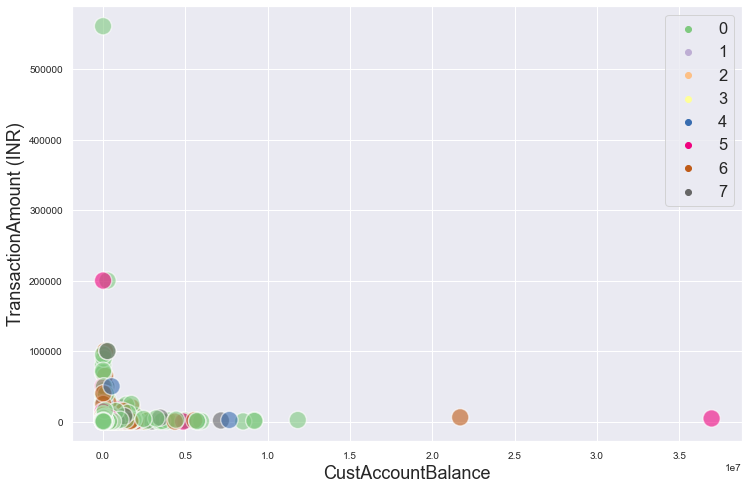

In [609]:
sns.scatterplot(data=data.sample(10000),x='CustAccountBalance',y='TransactionAmount (INR)',hue=base_spectral.labels_,s
                =300,alpha=0.6,palette="Accent")

### The Spectral clustering algorithm has identified the customers into two groups. 
#### • The first group is having dynamic customers having low account balance and frequently expend less cash on transactions barring a few who perform large-value transactions. 
#### • The second group includes the more conservative and money saving-minded people who, inspite of having really high account balances, spend the least amount of money in transactions, thereby judiciously maintaining their savings accounts.